In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [5]:
new_channels = []
for i in range(32):
  new_channels.append(i)

In [6]:
def simple_2D_CNN(x): 
  '''y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(36,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])'''
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 16, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 32, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 32, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 32, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Reshape((1, x.shape[1]))(x)
  y = MultiHeadAttention(num_heads=2, key_dim=2)(x, x)
  y = Activation('softmax')(y)
  x = Multiply()([x, y])
  x = Flatten()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (36, 256, 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 36, 256, 16)  272         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 36, 256, 16)  176         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 36, 256, 16)  112         ['input_1[0][0]']            

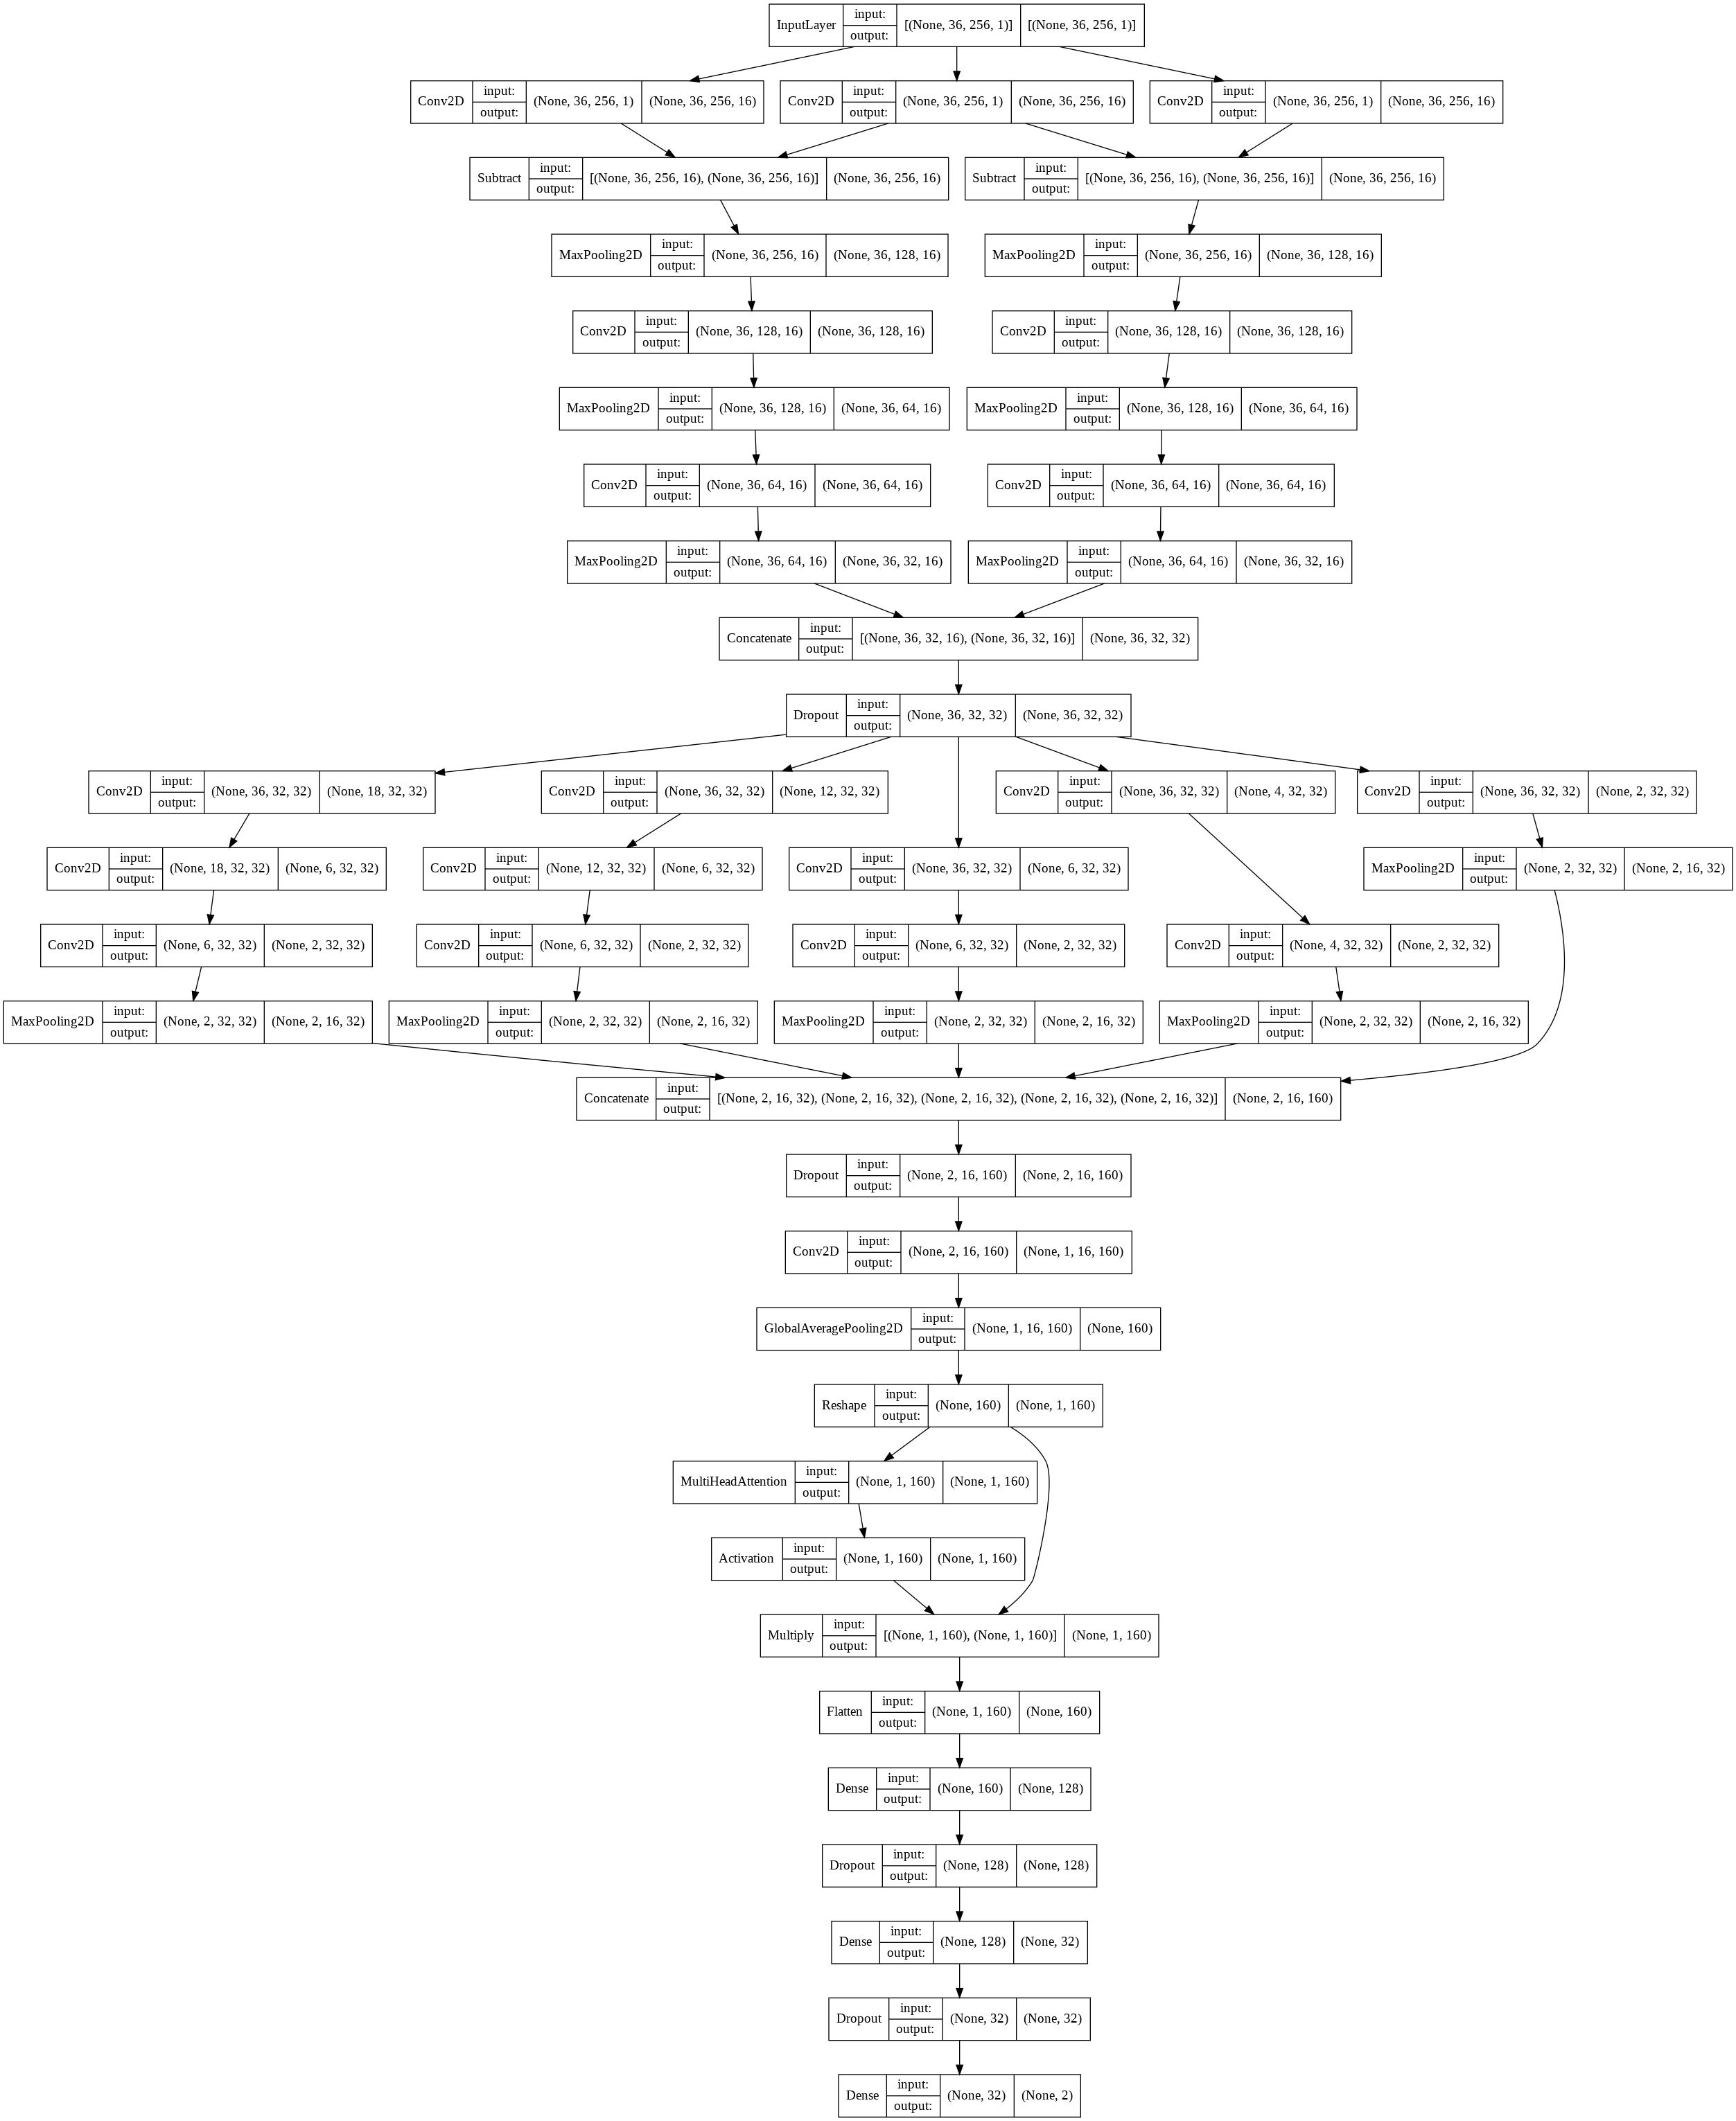

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [8]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [9]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

15670

In [10]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Subject 19**

In [11]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(19,20):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.19
(1200, 36, 256, 1)
(1200,) (510,) (690,)
(1200,) (390,) (810,)


0

# **Valence**

In [12]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 15s 117ms/step - loss: 0.6923 - accuracy: 0.4568 - val_loss: 0.6813 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6959 - accuracy: 0.5679 - val_loss: 0.6834 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6907 - accuracy: 0.5730 - val_loss: 0.6902 - val_accuracy: 0.4352
Epoch 4/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6890 - accuracy: 0.4990 - val_loss: 0.6779 - val_accuracy: 0.7778
Epoch 5/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6851 - accuracy: 0.6204 - val_loss: 0.6915 - val_accuracy: 0.4074
Epoch 6/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6833 - accuracy: 0.5679 - val_loss: 0.6669 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 1s 54ms/step - loss: 0.6716 - accuracy: 0.6337 - val_loss: 0.6241 - val_ac

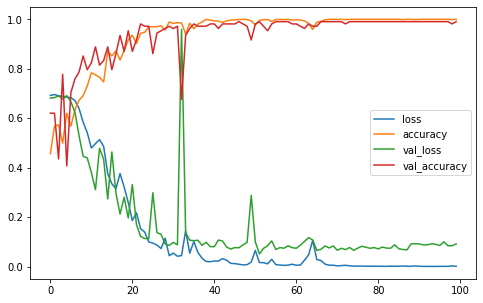

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 78ms/step - loss: 0.6933 - accuracy: 0.4218 - val_loss: 0.6918 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6921 - accuracy: 0.5689 - val_loss: 0.6902 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6900 - accuracy: 0.6080 - val_loss: 0.6880 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6865 - accuracy: 0.5072 - val_loss: 0.6816 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6803 - accuracy: 0.5885 - val_loss: 0.6638 - val_accuracy: 0.5926
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6683 - accuracy: 0.6049 - val_loss: 0.6461 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6373 - accuracy: 0.6862 - val_loss: 0.5816 - val_accu

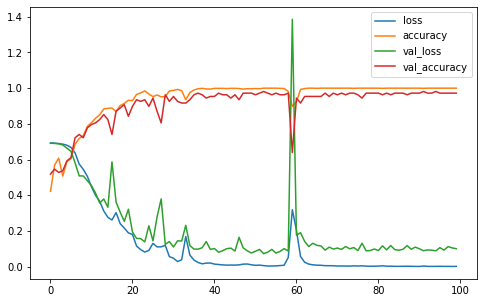

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6934 - accuracy: 0.5658 - val_loss: 0.6904 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6917 - accuracy: 0.5772 - val_loss: 0.6869 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6905 - accuracy: 0.6060 - val_loss: 0.6800 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6876 - accuracy: 0.5730 - val_loss: 0.6910 - val_accuracy: 0.5185
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6811 - accuracy: 0.5885 - val_loss: 0.6769 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6660 - accuracy: 0.6471 - val_loss: 0.6149 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6392 - accuracy: 0.6687 - val_loss: 0.5695 - val_accu

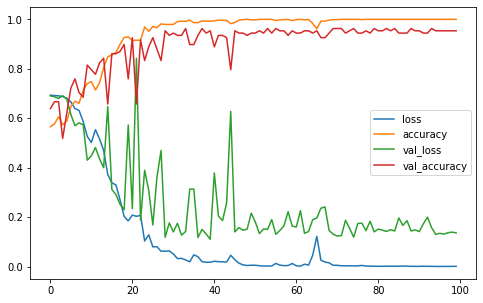

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6940 - accuracy: 0.4969 - val_loss: 0.6933 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6924 - accuracy: 0.5360 - val_loss: 0.6908 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6923 - accuracy: 0.4887 - val_loss: 0.6907 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6894 - accuracy: 0.5957 - val_loss: 0.6869 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6886 - accuracy: 0.5185 - val_loss: 0.6830 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6823 - accuracy: 0.5720 - val_loss: 0.6733 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6791 - accuracy: 0.5751 - val_loss: 0.6624 - val_accu

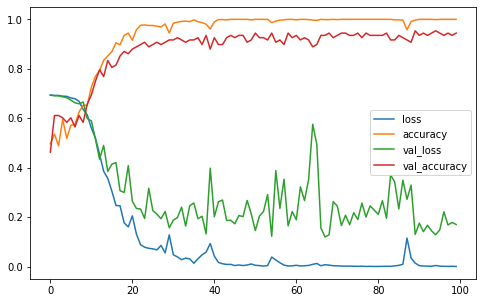

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6933 - accuracy: 0.5525 - val_loss: 0.6915 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6913 - accuracy: 0.5586 - val_loss: 0.6895 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6905 - accuracy: 0.4825 - val_loss: 0.6828 - val_accuracy: 0.5463
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6883 - accuracy: 0.5823 - val_loss: 0.6898 - val_accuracy: 0.4537
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6829 - accuracy: 0.5957 - val_loss: 0.6802 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6639 - accuracy: 0.6409 - val_loss: 0.6485 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6278 - accuracy: 0.6749 - val_loss: 0.6710 - val_accu

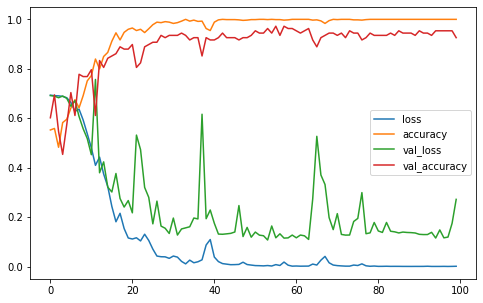

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6926 - accuracy: 0.5576 - val_loss: 0.6894 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.5926 - val_loss: 0.6853 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6877 - accuracy: 0.5844 - val_loss: 0.6754 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6778 - accuracy: 0.6451 - val_loss: 0.6632 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6678 - accuracy: 0.6379 - val_loss: 0.6509 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6355 - accuracy: 0.6986 - val_loss: 0.6119 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5852 - accuracy: 0.7212 - val_loss: 0.8127 - val_accu

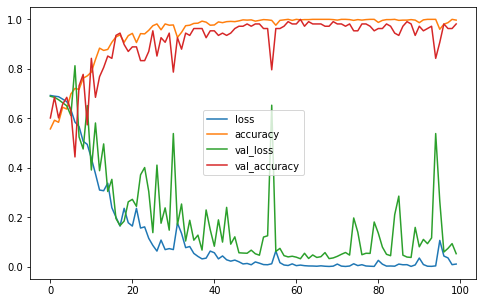

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6933 - accuracy: 0.4897 - val_loss: 0.6914 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6932 - accuracy: 0.4774 - val_loss: 0.6927 - val_accuracy: 0.4444
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6905 - accuracy: 0.5072 - val_loss: 0.6894 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6886 - accuracy: 0.5772 - val_loss: 0.6855 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6805 - accuracy: 0.6255 - val_loss: 0.7188 - val_accuracy: 0.3796
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6711 - accuracy: 0.5813 - val_loss: 0.6455 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6575 - accuracy: 0.6523 - val_loss: 0.6574 - val_accu

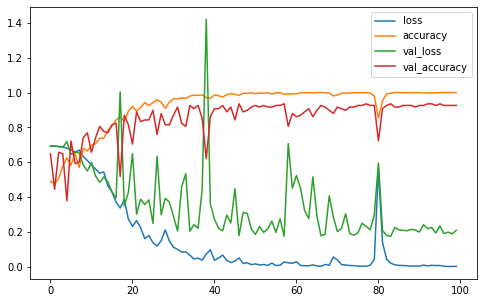

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6934 - accuracy: 0.4496 - val_loss: 0.6907 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6932 - accuracy: 0.5802 - val_loss: 0.6903 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6904 - accuracy: 0.5021 - val_loss: 0.6922 - val_accuracy: 0.4352
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6846 - accuracy: 0.5741 - val_loss: 0.6892 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6636 - accuracy: 0.6276 - val_loss: 0.6620 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6456 - accuracy: 0.6296 - val_loss: 0.6479 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6186 - accuracy: 0.6512 - val_loss: 0.6187 - val_accu

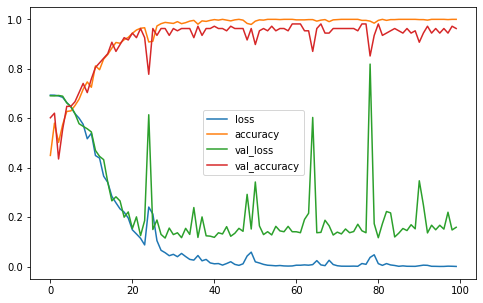

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6941 - accuracy: 0.5494 - val_loss: 0.6938 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6911 - accuracy: 0.5700 - val_loss: 0.6903 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6891 - accuracy: 0.5761 - val_loss: 0.6876 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6850 - accuracy: 0.6019 - val_loss: 0.6850 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6698 - accuracy: 0.6440 - val_loss: 0.6753 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6550 - accuracy: 0.5977 - val_loss: 0.6778 - val_accuracy: 0.5648
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6191 - accuracy: 0.6780 - val_loss: 0.6420 - val_accu

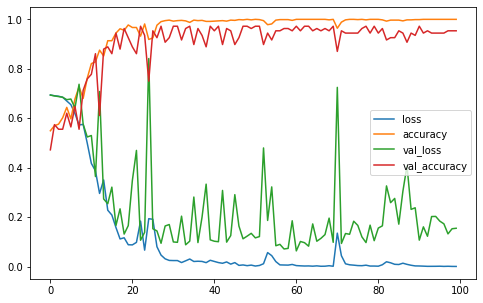

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6936 - accuracy: 0.5679 - val_loss: 0.6905 - val_accuracy: 0.6481
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6913 - accuracy: 0.5885 - val_loss: 0.6845 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6877 - accuracy: 0.6039 - val_loss: 0.6775 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6830 - accuracy: 0.5679 - val_loss: 0.7002 - val_accuracy: 0.4074
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6721 - accuracy: 0.6163 - val_loss: 0.6405 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6450 - accuracy: 0.6646 - val_loss: 0.6275 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6343 - accuracy: 0.6368 - val_loss: 0.5733 - val_acc

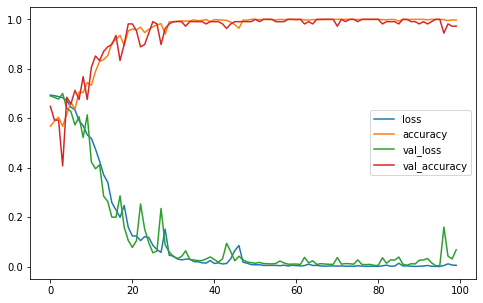

In [13]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.948333328962326
F1_Score  : 0.9477226338225442


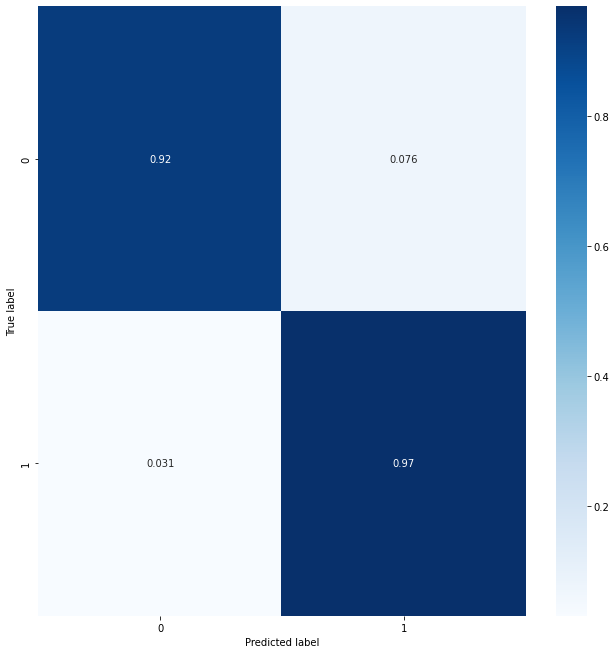

In [14]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [15]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6943 - accuracy: 0.4794 - val_loss: 0.6840 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6901 - accuracy: 0.4280 - val_loss: 0.6958 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6821 - accuracy: 0.5370 - val_loss: 0.6701 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6637 - accuracy: 0.5905 - val_loss: 0.6197 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6404 - accuracy: 0.6389 - val_loss: 0.5280 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5975 - accuracy: 0.6883 - val_loss: 0.5183 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5637 - accuracy: 0.6934 - val_loss: 0.4499 - val_accu

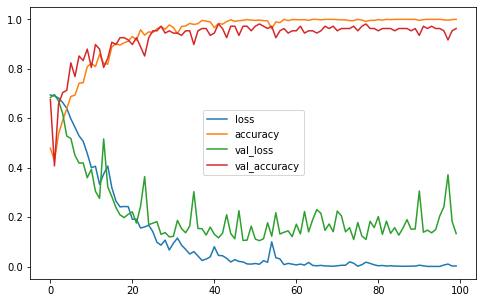

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6909 - accuracy: 0.5741 - val_loss: 0.7012 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6807 - accuracy: 0.4053 - val_loss: 0.6575 - val_accuracy: 0.7407
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6659 - accuracy: 0.6379 - val_loss: 0.6287 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6429 - accuracy: 0.6564 - val_loss: 0.6670 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6342 - accuracy: 0.6595 - val_loss: 0.6474 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6065 - accuracy: 0.6883 - val_loss: 0.5109 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5562 - accuracy: 0.7284 - val_loss: 0.5699 - val_accu

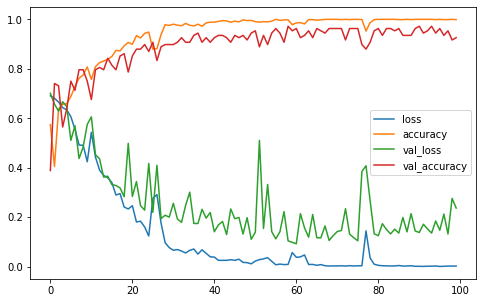

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6921 - accuracy: 0.3580 - val_loss: 0.6927 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6891 - accuracy: 0.3776 - val_loss: 0.6835 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6833 - accuracy: 0.5556 - val_loss: 0.6654 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6744 - accuracy: 0.5977 - val_loss: 0.6536 - val_accuracy: 0.7037
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6751 - accuracy: 0.6584 - val_loss: 0.6573 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6575 - accuracy: 0.6698 - val_loss: 0.6317 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6413 - accuracy: 0.6872 - val_loss: 0.5932 - val_accu

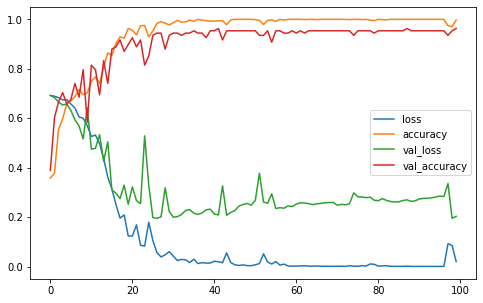

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6928 - accuracy: 0.5514 - val_loss: 0.6910 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6901 - accuracy: 0.3704 - val_loss: 0.7024 - val_accuracy: 0.3426
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6865 - accuracy: 0.5885 - val_loss: 0.6789 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6785 - accuracy: 0.6152 - val_loss: 0.6618 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6641 - accuracy: 0.6337 - val_loss: 0.6375 - val_accuracy: 0.7130
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6363 - accuracy: 0.6440 - val_loss: 0.5866 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5986 - accuracy: 0.7027 - val_loss: 0.5390 - val_accu

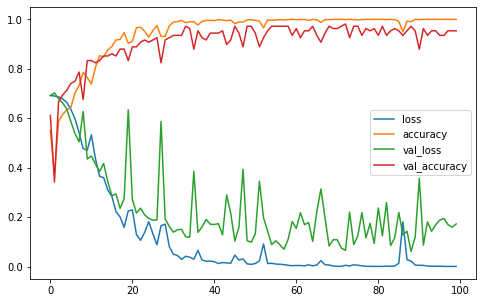

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6939 - accuracy: 0.3992 - val_loss: 0.6918 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6915 - accuracy: 0.3786 - val_loss: 0.6939 - val_accuracy: 0.3889
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6879 - accuracy: 0.4784 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6840 - accuracy: 0.4805 - val_loss: 0.6737 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6799 - accuracy: 0.6646 - val_loss: 0.7022 - val_accuracy: 0.4074
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6654 - accuracy: 0.4712 - val_loss: 0.6314 - val_accuracy: 0.7315
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6468 - accuracy: 0.6183 - val_loss: 0.6132 - val_accu

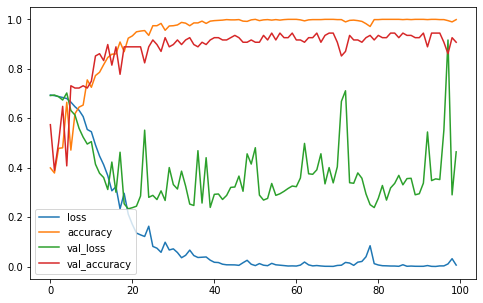

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6931 - accuracy: 0.6636 - val_loss: 0.6887 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6909 - accuracy: 0.3796 - val_loss: 0.6963 - val_accuracy: 0.3611
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6856 - accuracy: 0.4064 - val_loss: 0.6843 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6730 - accuracy: 0.5422 - val_loss: 0.6484 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6616 - accuracy: 0.6183 - val_loss: 0.6433 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6467 - accuracy: 0.6409 - val_loss: 0.6796 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6295 - accuracy: 0.6389 - val_loss: 0.5507 - val_accu

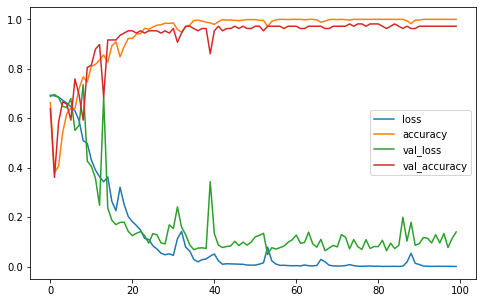

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6922 - accuracy: 0.5031 - val_loss: 0.6927 - val_accuracy: 0.4537
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6884 - accuracy: 0.3807 - val_loss: 0.6989 - val_accuracy: 0.4167
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6793 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6609 - accuracy: 0.5566 - val_loss: 0.6432 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6467 - accuracy: 0.6101 - val_loss: 0.6229 - val_accuracy: 0.7407
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6269 - accuracy: 0.6492 - val_loss: 0.5925 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5960 - accuracy: 0.6831 - val_loss: 0.5815 - val_accu

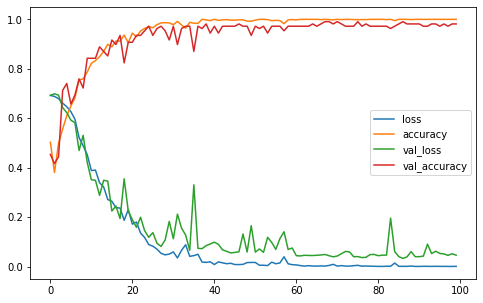

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6928 - accuracy: 0.3549 - val_loss: 0.7027 - val_accuracy: 0.2500
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6875 - accuracy: 0.3519 - val_loss: 0.7027 - val_accuracy: 0.3426
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6744 - accuracy: 0.4959 - val_loss: 0.6726 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6588 - accuracy: 0.6492 - val_loss: 0.5873 - val_accuracy: 0.7593
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6396 - accuracy: 0.6214 - val_loss: 0.7542 - val_accuracy: 0.4074
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6212 - accuracy: 0.6574 - val_loss: 0.5796 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5560 - accuracy: 0.7521 - val_loss: 0.6335 - val_accu

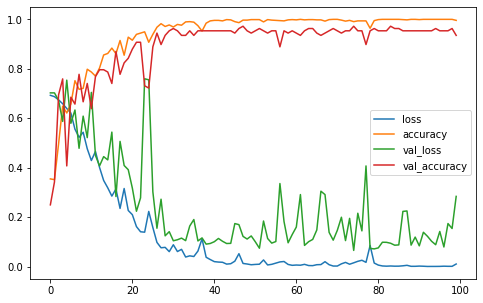

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6927 - accuracy: 0.5267 - val_loss: 0.6929 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6833 - accuracy: 0.4084 - val_loss: 0.6902 - val_accuracy: 0.4907
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6705 - accuracy: 0.5617 - val_loss: 0.6683 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6579 - accuracy: 0.6430 - val_loss: 0.6604 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6513 - accuracy: 0.6677 - val_loss: 0.6428 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6210 - accuracy: 0.7088 - val_loss: 0.6230 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5878 - accuracy: 0.7150 - val_loss: 0.5378 - val_accu

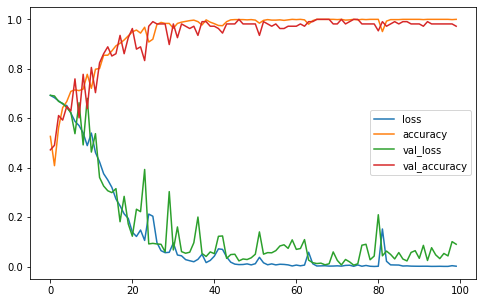

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6931 - accuracy: 0.6111 - val_loss: 0.6893 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6914 - accuracy: 0.5874 - val_loss: 0.6794 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6878 - accuracy: 0.6667 - val_loss: 0.6840 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6834 - accuracy: 0.6348 - val_loss: 0.6601 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6694 - accuracy: 0.6409 - val_loss: 0.6335 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6573 - accuracy: 0.5844 - val_loss: 0.7152 - val_accuracy: 0.4074
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6505 - accuracy: 0.6286 - val_loss: 0.5669 - val_acc

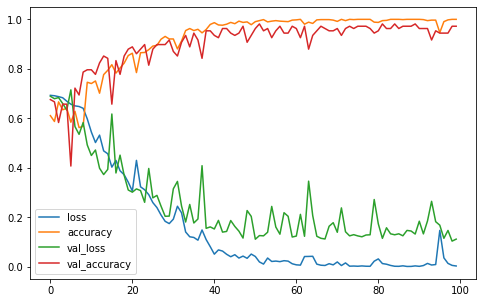

In [16]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9600000023841858
F1_Score  : 0.9491781776543078


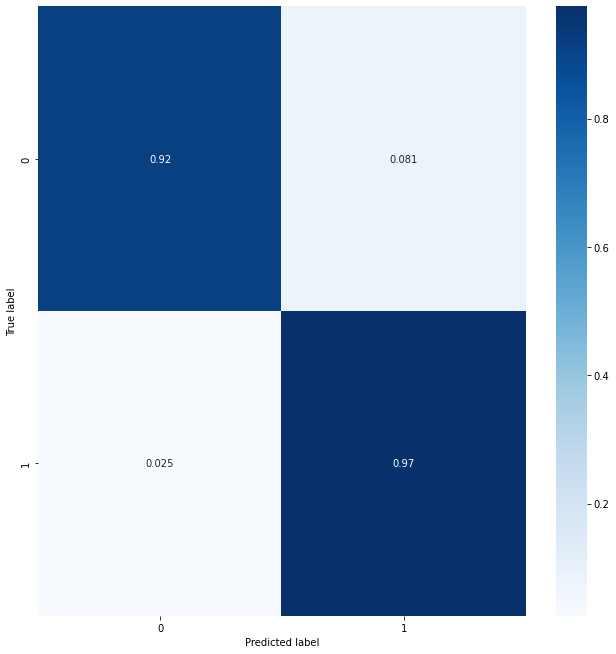

In [17]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 20**

In [18]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(20,21):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.20
(1200, 36, 256, 1)
(1200,) (510,) (690,)
(1200,) (270,) (930,)


3576

# **Valence**

In [19]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6937 - accuracy: 0.4290 - val_loss: 0.6924 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6921 - accuracy: 0.5679 - val_loss: 0.6855 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6895 - accuracy: 0.5823 - val_loss: 0.6887 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6832 - accuracy: 0.6224 - val_loss: 0.6830 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6680 - accuracy: 0.6101 - val_loss: 0.6363 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6431 - accuracy: 0.6245 - val_loss: 0.7291 - val_accuracy: 0.5185
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6108 - accuracy: 0.6626 - val_loss: 0.5690 - val_accu

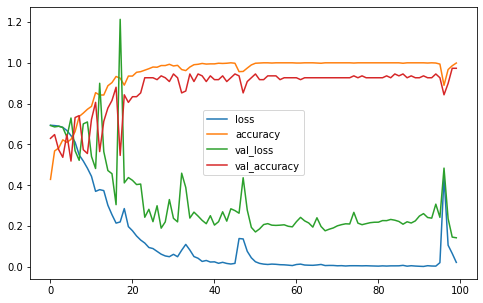

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6927 - accuracy: 0.5916 - val_loss: 0.6919 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6927 - accuracy: 0.4455 - val_loss: 0.6914 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6884 - accuracy: 0.5628 - val_loss: 0.6889 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6834 - accuracy: 0.5802 - val_loss: 0.6819 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6541 - accuracy: 0.6584 - val_loss: 0.6673 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6080 - accuracy: 0.6770 - val_loss: 0.5935 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5336 - accuracy: 0.7840 - val_loss: 0.5811 - val_accu

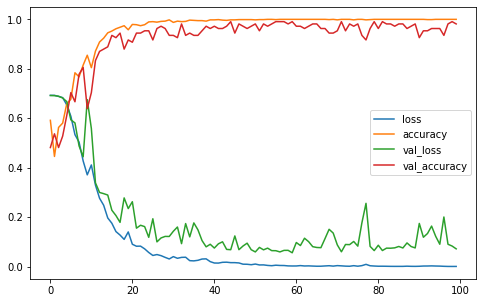

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6931 - accuracy: 0.4475 - val_loss: 0.6923 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6920 - accuracy: 0.5082 - val_loss: 0.6929 - val_accuracy: 0.3981
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6899 - accuracy: 0.4753 - val_loss: 0.6842 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6846 - accuracy: 0.5504 - val_loss: 0.6741 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6735 - accuracy: 0.5772 - val_loss: 0.6684 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6624 - accuracy: 0.6163 - val_loss: 0.6108 - val_accuracy: 0.7963
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5933 - accuracy: 0.7140 - val_loss: 0.5132 - val_accu

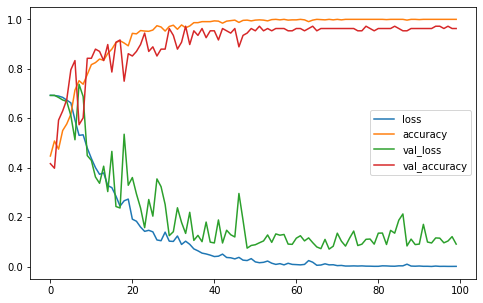

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6929 - accuracy: 0.5586 - val_loss: 0.6913 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6899 - accuracy: 0.5988 - val_loss: 0.6823 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6867 - accuracy: 0.5905 - val_loss: 0.6846 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6781 - accuracy: 0.6039 - val_loss: 0.6602 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6663 - accuracy: 0.6101 - val_loss: 0.6378 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6367 - accuracy: 0.6492 - val_loss: 0.5661 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5824 - accuracy: 0.7119 - val_loss: 0.5684 - val_accu

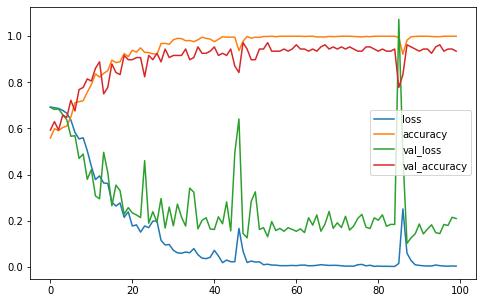

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6928 - accuracy: 0.5586 - val_loss: 0.6898 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6895 - accuracy: 0.5947 - val_loss: 0.6889 - val_accuracy: 0.5556
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6839 - accuracy: 0.6358 - val_loss: 0.6794 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6730 - accuracy: 0.6245 - val_loss: 0.6606 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6536 - accuracy: 0.6245 - val_loss: 0.6456 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6132 - accuracy: 0.6626 - val_loss: 0.6113 - val_accuracy: 0.6481
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5532 - accuracy: 0.7387 - val_loss: 0.5823 - val_accu

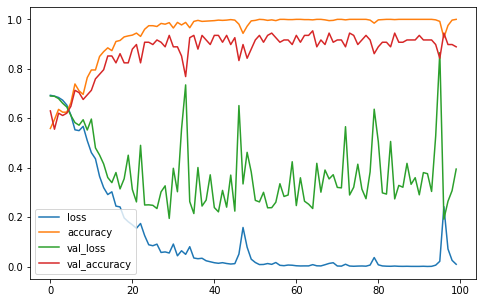

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6928 - accuracy: 0.4516 - val_loss: 0.6907 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6900 - accuracy: 0.5669 - val_loss: 0.6932 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6856 - accuracy: 0.5257 - val_loss: 0.6812 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6771 - accuracy: 0.5936 - val_loss: 0.6722 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6669 - accuracy: 0.6008 - val_loss: 0.6467 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6506 - accuracy: 0.6296 - val_loss: 0.6131 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5984 - accuracy: 0.6944 - val_loss: 0.6202 - val_accu

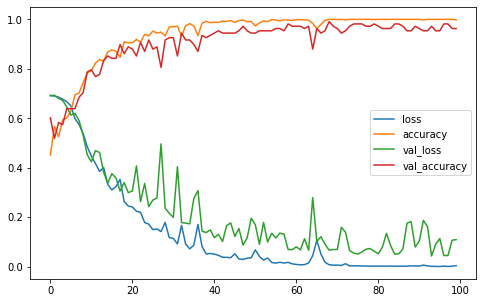

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6921 - accuracy: 0.5730 - val_loss: 0.6890 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6902 - accuracy: 0.5813 - val_loss: 0.6846 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6848 - accuracy: 0.5628 - val_loss: 0.6717 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6746 - accuracy: 0.6163 - val_loss: 0.6526 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6636 - accuracy: 0.5998 - val_loss: 0.6342 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6437 - accuracy: 0.6502 - val_loss: 0.5884 - val_accuracy: 0.7037
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6070 - accuracy: 0.6790 - val_loss: 0.5416 - val_accu

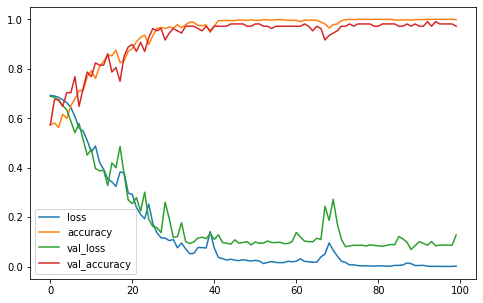

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6924 - accuracy: 0.5761 - val_loss: 0.6859 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6901 - accuracy: 0.6019 - val_loss: 0.6824 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6846 - accuracy: 0.6111 - val_loss: 0.6713 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6704 - accuracy: 0.6379 - val_loss: 0.6438 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6437 - accuracy: 0.6543 - val_loss: 0.6713 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6520 - accuracy: 0.5638 - val_loss: 0.6110 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6198 - accuracy: 0.6656 - val_loss: 0.5553 - val_accu

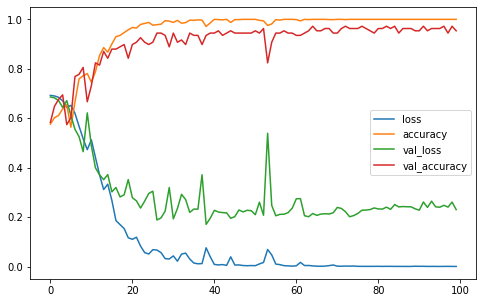

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6929 - accuracy: 0.5525 - val_loss: 0.6895 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6899 - accuracy: 0.5936 - val_loss: 0.6825 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6784 - accuracy: 0.5916 - val_loss: 0.6572 - val_accuracy: 0.6481
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6461 - accuracy: 0.6574 - val_loss: 0.6403 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6288 - accuracy: 0.6389 - val_loss: 0.6797 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5958 - accuracy: 0.6944 - val_loss: 0.5860 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5636 - accuracy: 0.7315 - val_loss: 0.6440 - val_accu

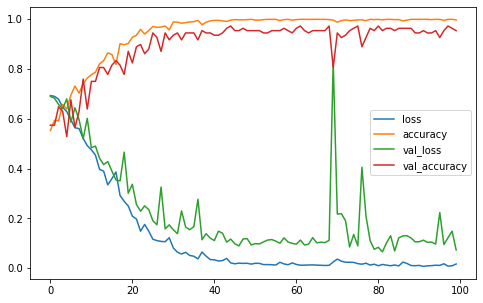

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6935 - accuracy: 0.4280 - val_loss: 0.6924 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6915 - accuracy: 0.5597 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.4805 - val_loss: 0.6817 - val_accuracy: 0.6389
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6807 - accuracy: 0.5864 - val_loss: 0.6590 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6780 - accuracy: 0.5864 - val_loss: 0.6662 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6609 - accuracy: 0.6121 - val_loss: 0.6227 - val_accuracy: 0.6574
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6250 - accuracy: 0.6903 - val_loss: 0.5574 - val_acc

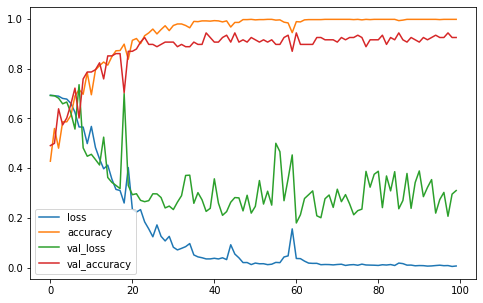

In [20]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9699999988079071
F1_Score  : 0.9696283237880154


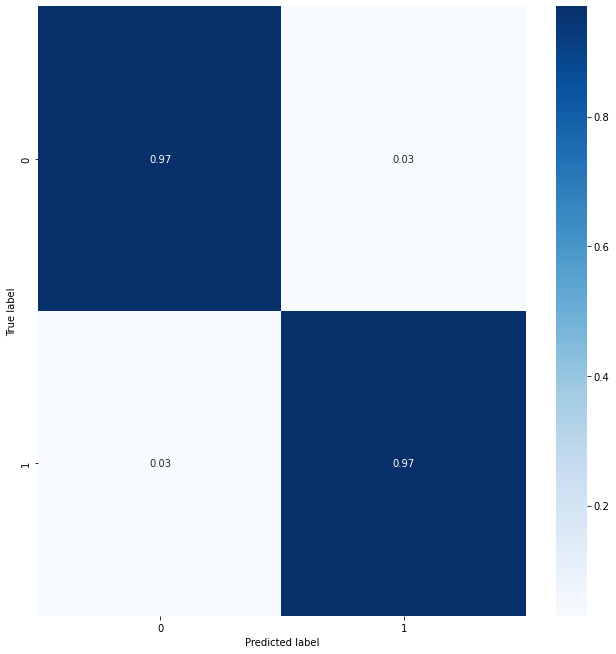

In [21]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [22]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6941 - accuracy: 0.6307 - val_loss: 0.6873 - val_accuracy: 0.7037
Epoch 2/100
16/16 [==============================] - 1s 55ms/step - loss: 0.6934 - accuracy: 0.4660 - val_loss: 0.6936 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6923 - accuracy: 0.3930 - val_loss: 0.6942 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6913 - accuracy: 0.5237 - val_loss: 0.6946 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6910 - accuracy: 0.2644 - val_loss: 0.6950 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6879 - accuracy: 0.6440 - val_loss: 0.6914 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6841 - accuracy: 0.5710 - val_loss: 0.6740 - val_accu

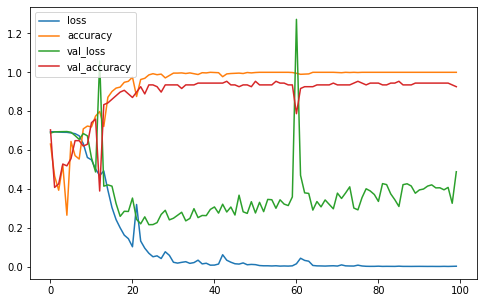

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6939 - accuracy: 0.7654 - val_loss: 0.6851 - val_accuracy: 0.7315
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6932 - accuracy: 0.3302 - val_loss: 0.6988 - val_accuracy: 0.2685
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6926 - accuracy: 0.3549 - val_loss: 0.6918 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6924 - accuracy: 0.7449 - val_loss: 0.6763 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6902 - accuracy: 0.7675 - val_loss: 0.6766 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6903 - accuracy: 0.7623 - val_loss: 0.6976 - val_accuracy: 0.3333
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6882 - accuracy: 0.5175 - val_loss: 0.6597 - val_accu

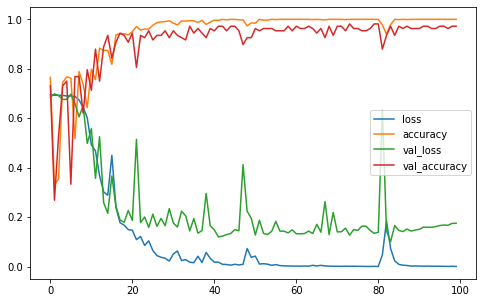

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6944 - accuracy: 0.6214 - val_loss: 0.6897 - val_accuracy: 0.8241
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6924 - accuracy: 0.7263 - val_loss: 0.6901 - val_accuracy: 0.7870
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6918 - accuracy: 0.3477 - val_loss: 0.6991 - val_accuracy: 0.1759
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6907 - accuracy: 0.5051 - val_loss: 0.6948 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6889 - accuracy: 0.5144 - val_loss: 0.7004 - val_accuracy: 0.3148
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6852 - accuracy: 0.4990 - val_loss: 0.6490 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6800 - accuracy: 0.6646 - val_loss: 0.6796 - val_accu

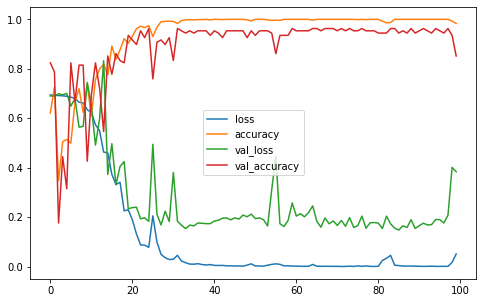

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6932 - accuracy: 0.6307 - val_loss: 0.6880 - val_accuracy: 0.7870
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6927 - accuracy: 0.5021 - val_loss: 0.6943 - val_accuracy: 0.4352
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6914 - accuracy: 0.3899 - val_loss: 0.7035 - val_accuracy: 0.2130
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6908 - accuracy: 0.2819 - val_loss: 0.6970 - val_accuracy: 0.2963
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6888 - accuracy: 0.4990 - val_loss: 0.6755 - val_accuracy: 0.8241
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6843 - accuracy: 0.6070 - val_loss: 0.6994 - val_accuracy: 0.3796
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6806 - accuracy: 0.4938 - val_loss: 0.6511 - val_accu

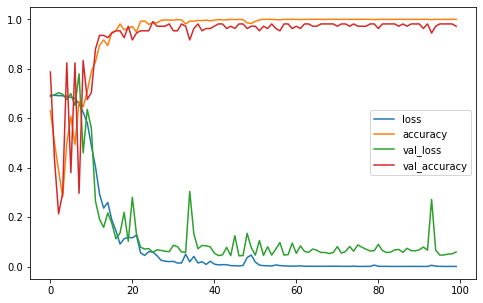

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6931 - accuracy: 0.4897 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 2/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6927 - accuracy: 0.4198 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6921 - accuracy: 0.6584 - val_loss: 0.6893 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6907 - accuracy: 0.7047 - val_loss: 0.6866 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6880 - accuracy: 0.4095 - val_loss: 0.6729 - val_accuracy: 0.7778
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6828 - accuracy: 0.6574 - val_loss: 0.6899 - val_accuracy: 0.4907
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6742 - accuracy: 0.4733 - val_loss: 0.6572 - val_accu

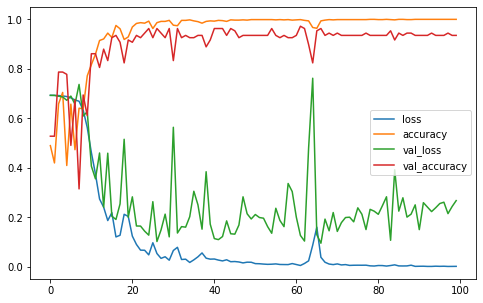

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6939 - accuracy: 0.3148 - val_loss: 0.6855 - val_accuracy: 0.8056
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6926 - accuracy: 0.7253 - val_loss: 0.6869 - val_accuracy: 0.7685
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6935 - accuracy: 0.2901 - val_loss: 0.7011 - val_accuracy: 0.1944
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6909 - accuracy: 0.3745 - val_loss: 0.6884 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6901 - accuracy: 0.7521 - val_loss: 0.6861 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6889 - accuracy: 0.3025 - val_loss: 0.7046 - val_accuracy: 0.3333
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6855 - accuracy: 0.4558 - val_loss: 0.6798 - val_accu

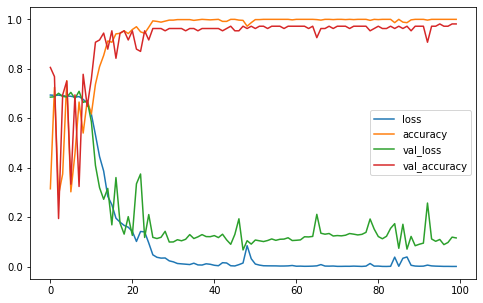

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6939 - accuracy: 0.7253 - val_loss: 0.6907 - val_accuracy: 0.7963
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6935 - accuracy: 0.3056 - val_loss: 0.6942 - val_accuracy: 0.3426
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6930 - accuracy: 0.7263 - val_loss: 0.6745 - val_accuracy: 0.7685
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6916 - accuracy: 0.6121 - val_loss: 0.6954 - val_accuracy: 0.2963
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.6430 - val_loss: 0.6835 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6884 - accuracy: 0.6492 - val_loss: 0.7120 - val_accuracy: 0.2315
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6851 - accuracy: 0.6492 - val_loss: 0.6847 - val_accu

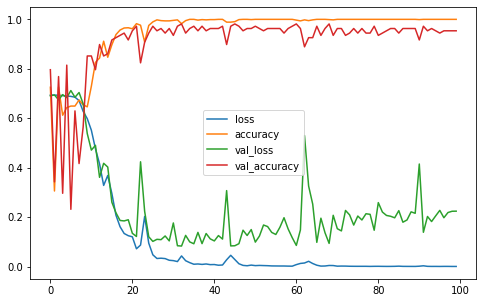

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6967 - val_accuracy: 0.2130
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6925 - accuracy: 0.5319 - val_loss: 0.6863 - val_accuracy: 0.7963
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6914 - accuracy: 0.4702 - val_loss: 0.6915 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6887 - accuracy: 0.4547 - val_loss: 0.6788 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6831 - accuracy: 0.5288 - val_loss: 0.6455 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6772 - accuracy: 0.5998 - val_loss: 0.6359 - val_accuracy: 0.8056
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6618 - accuracy: 0.6934 - val_loss: 0.5939 - val_accu

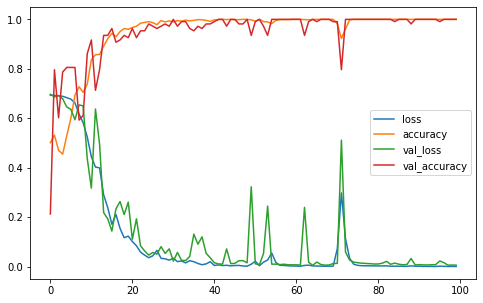

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6936 - accuracy: 0.2593 - val_loss: 0.6946 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6926 - accuracy: 0.5514 - val_loss: 0.6874 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6928 - accuracy: 0.7675 - val_loss: 0.6863 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6902 - accuracy: 0.6163 - val_loss: 0.6984 - val_accuracy: 0.3704
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6891 - accuracy: 0.6111 - val_loss: 0.6886 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6840 - accuracy: 0.6996 - val_loss: 0.7162 - val_accuracy: 0.3333
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6862 - accuracy: 0.6790 - val_loss: 0.7008 - val_accu

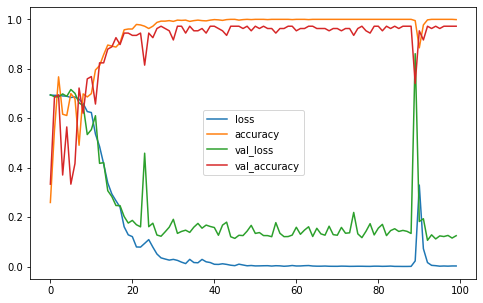

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6926 - accuracy: 0.6749 - val_loss: 0.6870 - val_accuracy: 0.8148
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6914 - accuracy: 0.7479 - val_loss: 0.6847 - val_accuracy: 0.8333
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6878 - accuracy: 0.6944 - val_loss: 0.6771 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6779 - accuracy: 0.7294 - val_loss: 0.7212 - val_accuracy: 0.3333
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6610 - accuracy: 0.6440 - val_loss: 0.7825 - val_accuracy: 0.2963
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6491 - accuracy: 0.5926 - val_loss: 0.6580 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5932 - accuracy: 0.7377 - val_loss: 0.6518 - val_acc

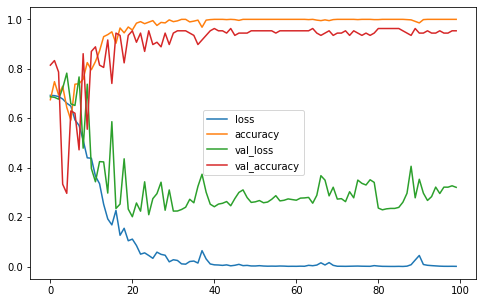

In [23]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.978333342075348
F1_Score  : 0.958790482437327


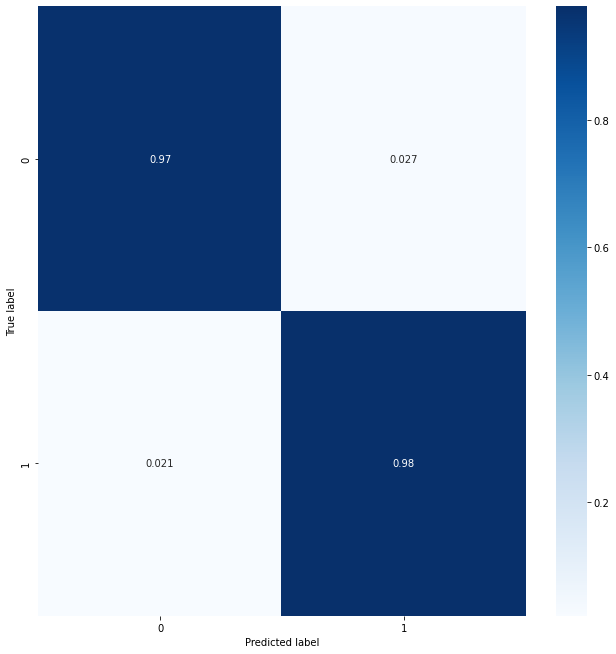

In [24]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 21**

In [25]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(21,22):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.21
(1200, 36, 256, 1)
(1200,) (570,) (630,)
(1200,) (240,) (960,)


3576

# **Valence**

In [26]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6906 - accuracy: 0.5298 - val_loss: 0.6821 - val_accuracy: 0.5185
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6870 - accuracy: 0.5370 - val_loss: 0.6766 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6800 - accuracy: 0.5638 - val_loss: 0.6747 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6760 - accuracy: 0.5720 - val_loss: 0.6829 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6765 - accuracy: 0.5638 - val_loss: 0.6474 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6665 - accuracy: 0.5813 - val_loss: 0.6347 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6772 - accuracy: 0.5638 - val_loss: 0.6661 - val_accu

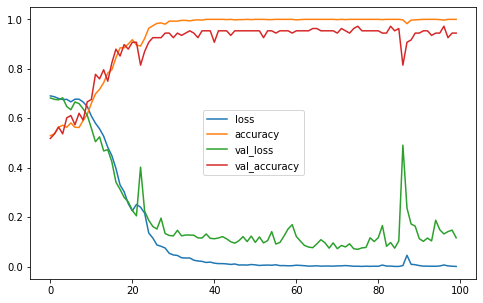

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6914 - accuracy: 0.5247 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6878 - accuracy: 0.5247 - val_loss: 0.6752 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6831 - accuracy: 0.5967 - val_loss: 0.6678 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6758 - accuracy: 0.5658 - val_loss: 0.6563 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6644 - accuracy: 0.5854 - val_loss: 0.6308 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6514 - accuracy: 0.6101 - val_loss: 0.6301 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6256 - accuracy: 0.6430 - val_loss: 0.6059 - val_accu

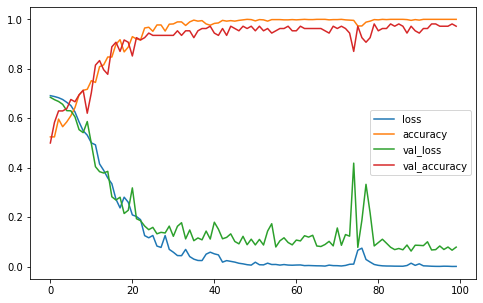

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6938 - accuracy: 0.4753 - val_loss: 0.6939 - val_accuracy: 0.4722
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6882 - accuracy: 0.5391 - val_loss: 0.7073 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6849 - accuracy: 0.5422 - val_loss: 0.6967 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6831 - accuracy: 0.5535 - val_loss: 0.7032 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6753 - accuracy: 0.5556 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6711 - accuracy: 0.5720 - val_loss: 0.7135 - val_accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6625 - accuracy: 0.5802 - val_loss: 0.6926 - val_accu

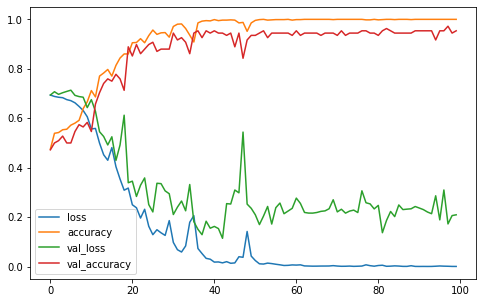

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6921 - accuracy: 0.5082 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6851 - accuracy: 0.5874 - val_loss: 0.6840 - val_accuracy: 0.4815
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6813 - accuracy: 0.5525 - val_loss: 0.6781 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6758 - accuracy: 0.5689 - val_loss: 0.6794 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6757 - accuracy: 0.5741 - val_loss: 0.6725 - val_accuracy: 0.4815
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6680 - accuracy: 0.5813 - val_loss: 0.6632 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6590 - accuracy: 0.6152 - val_loss: 0.6495 - val_accu

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6927 - accuracy: 0.5175 - val_loss: 0.6861 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6870 - accuracy: 0.5175 - val_loss: 0.6766 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6866 - accuracy: 0.5298 - val_loss: 0.6827 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6824 - accuracy: 0.5823 - val_loss: 0.6699 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6782 - accuracy: 0.5792 - val_loss: 0.6676 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6723 - accuracy: 0.5967 - val_loss: 0.6767 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6640 - accuracy: 0.6121 - val_loss: 0.6511 - val_accu

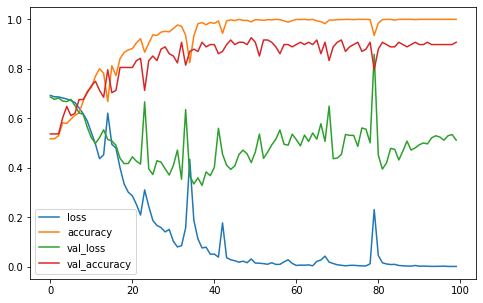

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6913 - accuracy: 0.5093 - val_loss: 0.6827 - val_accuracy: 0.5926
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6870 - accuracy: 0.5134 - val_loss: 0.6783 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6785 - accuracy: 0.5638 - val_loss: 0.6815 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6775 - accuracy: 0.5689 - val_loss: 0.6755 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6693 - accuracy: 0.5792 - val_loss: 0.6682 - val_accuracy: 0.4907
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6600 - accuracy: 0.5998 - val_loss: 0.6629 - val_accuracy: 0.5185
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6358 - accuracy: 0.6317 - val_loss: 0.6390 - val_accu

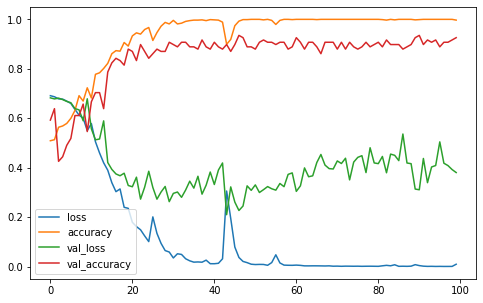

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6926 - accuracy: 0.5226 - val_loss: 0.6900 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6897 - accuracy: 0.5247 - val_loss: 0.6853 - val_accuracy: 0.6667
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6844 - accuracy: 0.5710 - val_loss: 0.6771 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6788 - accuracy: 0.5628 - val_loss: 0.6704 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6682 - accuracy: 0.5730 - val_loss: 0.6563 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6462 - accuracy: 0.6152 - val_loss: 0.6457 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6722 - accuracy: 0.5761 - val_loss: 0.6472 - val_accu

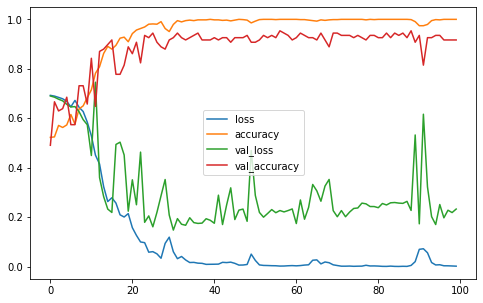

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6806 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6879 - accuracy: 0.5288 - val_loss: 0.6651 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6836 - accuracy: 0.5638 - val_loss: 0.6656 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6828 - accuracy: 0.5936 - val_loss: 0.6740 - val_accuracy: 0.6481
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6711 - accuracy: 0.5967 - val_loss: 0.6239 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6865 - accuracy: 0.5545 - val_loss: 0.6676 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6681 - accuracy: 0.5802 - val_loss: 0.6246 - val_accu

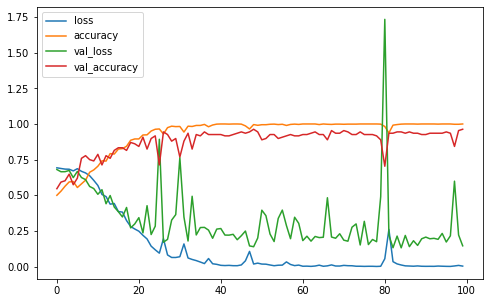

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6920 - accuracy: 0.5257 - val_loss: 0.6934 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6857 - accuracy: 0.5628 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6831 - accuracy: 0.5679 - val_loss: 0.6878 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6775 - accuracy: 0.5648 - val_loss: 0.6857 - val_accuracy: 0.5185
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6706 - accuracy: 0.5586 - val_loss: 0.6759 - val_accuracy: 0.5833
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6567 - accuracy: 0.6060 - val_loss: 0.6578 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6319 - accuracy: 0.6451 - val_loss: 0.6300 - val_accu

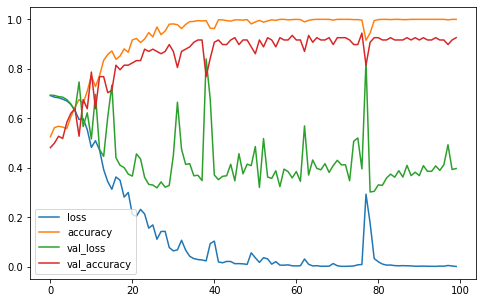

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6922 - accuracy: 0.5144 - val_loss: 0.6886 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6881 - accuracy: 0.5360 - val_loss: 0.6804 - val_accuracy: 0.5370
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6876 - accuracy: 0.5340 - val_loss: 0.6868 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6801 - accuracy: 0.5916 - val_loss: 0.6732 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6794 - accuracy: 0.5730 - val_loss: 0.6753 - val_accuracy: 0.5463
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6683 - accuracy: 0.5772 - val_loss: 0.6597 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6645 - accuracy: 0.5998 - val_loss: 0.6478 - val_acc

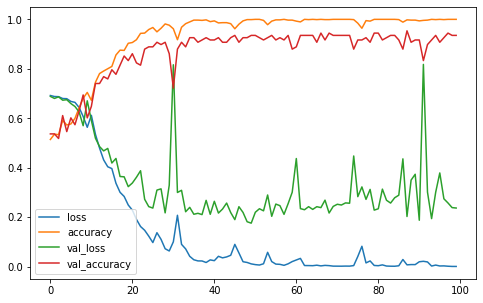

In [27]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9358333349227905
F1_Score  : 0.9347813989436906


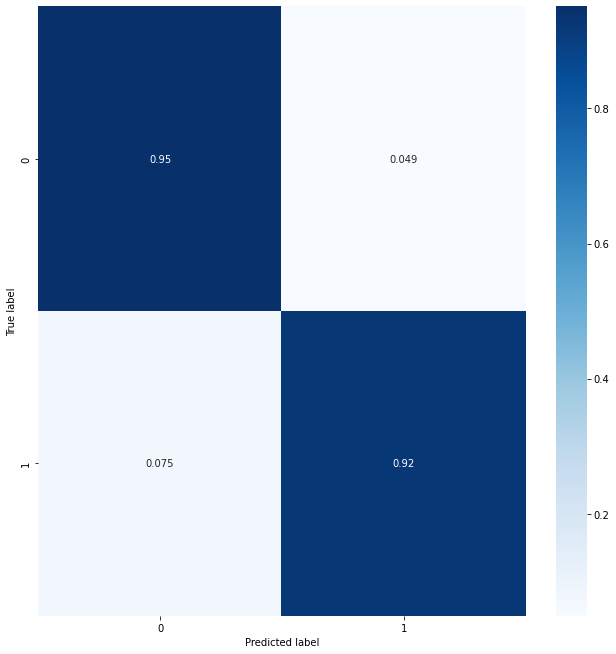

In [28]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [29]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6906 - accuracy: 0.2747 - val_loss: 0.7183 - val_accuracy: 0.2037
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6802 - accuracy: 0.3436 - val_loss: 0.6968 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6720 - accuracy: 0.6307 - val_loss: 0.6485 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6582 - accuracy: 0.6955 - val_loss: 0.6105 - val_accuracy: 0.8241
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6696 - accuracy: 0.7099 - val_loss: 0.6479 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6506 - accuracy: 0.7716 - val_loss: 0.6607 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6357 - accuracy: 0.7418 - val_loss: 0.6029 - val_accu

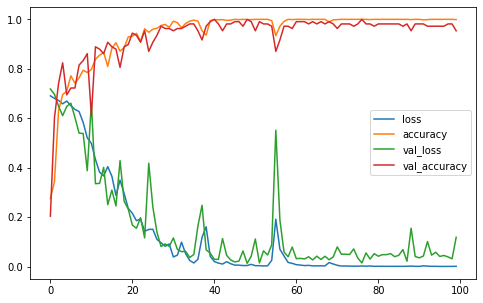

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 79ms/step - loss: 0.6890 - accuracy: 0.4053 - val_loss: 0.7200 - val_accuracy: 0.2778
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6799 - accuracy: 0.2562 - val_loss: 0.6859 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6732 - accuracy: 0.5792 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6622 - accuracy: 0.6379 - val_loss: 0.6327 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6542 - accuracy: 0.7294 - val_loss: 0.6372 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6259 - accuracy: 0.7551 - val_loss: 0.5522 - val_accuracy: 0.8056
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6127 - accuracy: 0.7747 - val_loss: 0.5371 - val_accu

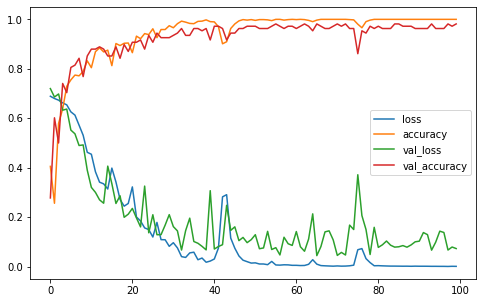

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6907 - accuracy: 0.2140 - val_loss: 0.7189 - val_accuracy: 0.1481
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6762 - accuracy: 0.3169 - val_loss: 0.7065 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6677 - accuracy: 0.6543 - val_loss: 0.6406 - val_accuracy: 0.8426
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6530 - accuracy: 0.7356 - val_loss: 0.6072 - val_accuracy: 0.8611
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6560 - accuracy: 0.7644 - val_loss: 0.6851 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6349 - accuracy: 0.7407 - val_loss: 0.5787 - val_accuracy: 0.8519
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6381 - accuracy: 0.7418 - val_loss: 0.5875 - val_accu

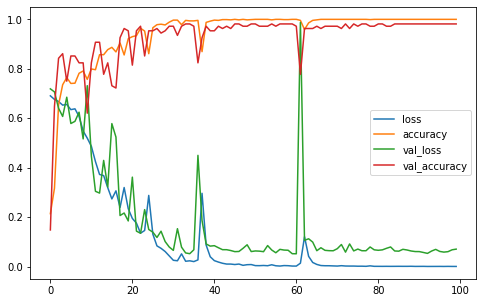

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6957 - accuracy: 0.7130 - val_loss: 0.6908 - val_accuracy: 0.7130
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6901 - accuracy: 0.2634 - val_loss: 0.7227 - val_accuracy: 0.1759
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6779 - accuracy: 0.2994 - val_loss: 0.7210 - val_accuracy: 0.4815
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6686 - accuracy: 0.5700 - val_loss: 0.7059 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6608 - accuracy: 0.6553 - val_loss: 0.6420 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6520 - accuracy: 0.7222 - val_loss: 0.6627 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6400 - accuracy: 0.7366 - val_loss: 0.6663 - val_accu

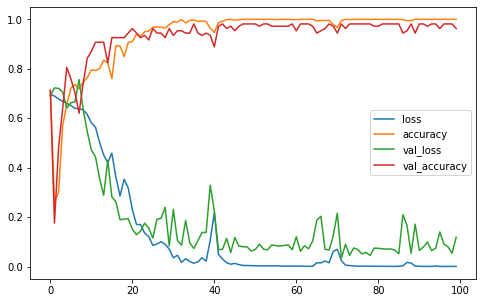

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6906 - accuracy: 0.6430 - val_loss: 0.7133 - val_accuracy: 0.2593
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6837 - accuracy: 0.2819 - val_loss: 0.7061 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6750 - accuracy: 0.5658 - val_loss: 0.6937 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6587 - accuracy: 0.6739 - val_loss: 0.6180 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6438 - accuracy: 0.7027 - val_loss: 0.6798 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6182 - accuracy: 0.7500 - val_loss: 0.5335 - val_accuracy: 0.7870
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5877 - accuracy: 0.7644 - val_loss: 0.4609 - val_accu

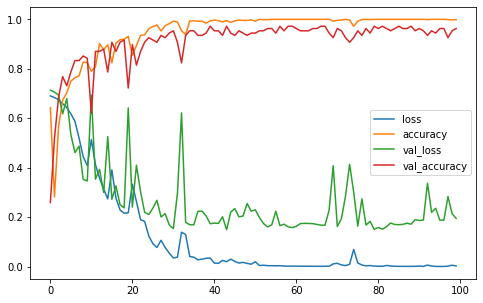

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6925 - accuracy: 0.3056 - val_loss: 0.6935 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6872 - accuracy: 0.5504 - val_loss: 0.7116 - val_accuracy: 0.2222
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6819 - accuracy: 0.4208 - val_loss: 0.6496 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6670 - accuracy: 0.6368 - val_loss: 0.6260 - val_accuracy: 0.7963
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6547 - accuracy: 0.7130 - val_loss: 0.5970 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6487 - accuracy: 0.7191 - val_loss: 0.5389 - val_accuracy: 0.8796
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6203 - accuracy: 0.7562 - val_loss: 0.5294 - val_accu

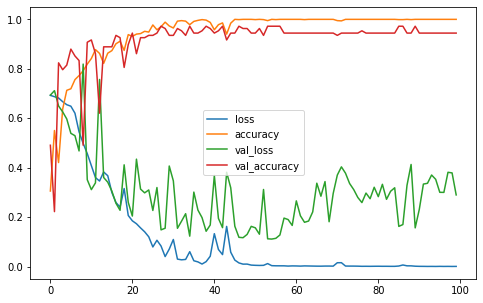

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6904 - accuracy: 0.3004 - val_loss: 0.6984 - val_accuracy: 0.3981
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6816 - accuracy: 0.4733 - val_loss: 0.7117 - val_accuracy: 0.3704
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6750 - accuracy: 0.5360 - val_loss: 0.6819 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6671 - accuracy: 0.6944 - val_loss: 0.6976 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6472 - accuracy: 0.6862 - val_loss: 0.5982 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6446 - accuracy: 0.7449 - val_loss: 0.6452 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6139 - accuracy: 0.7397 - val_loss: 0.5941 - val_accu

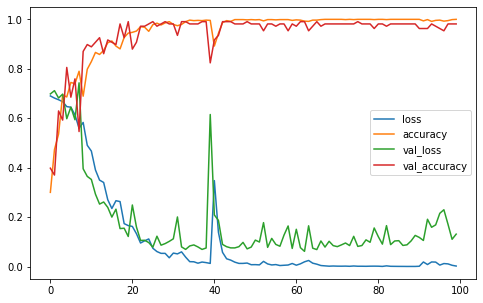

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6929 - accuracy: 0.4362 - val_loss: 0.6975 - val_accuracy: 0.2500
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6860 - accuracy: 0.4702 - val_loss: 0.7175 - val_accuracy: 0.2500
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6762 - accuracy: 0.3097 - val_loss: 0.6816 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6644 - accuracy: 0.6492 - val_loss: 0.6983 - val_accuracy: 0.5926
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6538 - accuracy: 0.6986 - val_loss: 0.6475 - val_accuracy: 0.6574
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6450 - accuracy: 0.7284 - val_loss: 0.5986 - val_accuracy: 0.7870
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6112 - accuracy: 0.7840 - val_loss: 0.5599 - val_accu

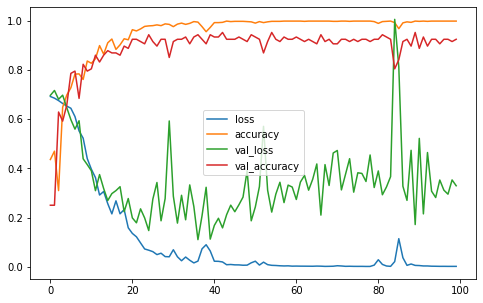

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6923 - accuracy: 0.5031 - val_loss: 0.6969 - val_accuracy: 0.2870
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6877 - accuracy: 0.4146 - val_loss: 0.6914 - val_accuracy: 0.5648
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6784 - accuracy: 0.5010 - val_loss: 0.6368 - val_accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6743 - accuracy: 0.6687 - val_loss: 0.6360 - val_accuracy: 0.7870
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6602 - accuracy: 0.6605 - val_loss: 0.6084 - val_accuracy: 0.7870
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6535 - accuracy: 0.7212 - val_loss: 0.5711 - val_accuracy: 0.7963
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6200 - accuracy: 0.7623 - val_loss: 0.5123 - val_accu

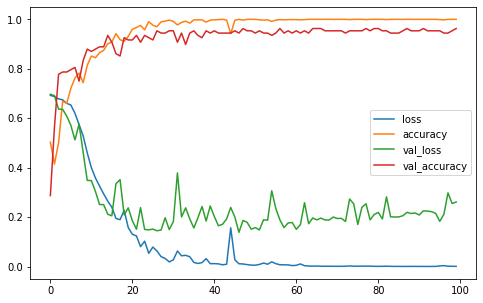

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6919 - accuracy: 0.7562 - val_loss: 0.6993 - val_accuracy: 0.4352
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6792 - accuracy: 0.2407 - val_loss: 0.6920 - val_accuracy: 0.6852
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6638 - accuracy: 0.7058 - val_loss: 0.6089 - val_accuracy: 0.7870
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6486 - accuracy: 0.7459 - val_loss: 0.6251 - val_accuracy: 0.7407
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6183 - accuracy: 0.7665 - val_loss: 0.5583 - val_accuracy: 0.7963
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5683 - accuracy: 0.7551 - val_loss: 0.4356 - val_accuracy: 0.8426
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6177 - accuracy: 0.6749 - val_loss: 0.4825 - val_acc

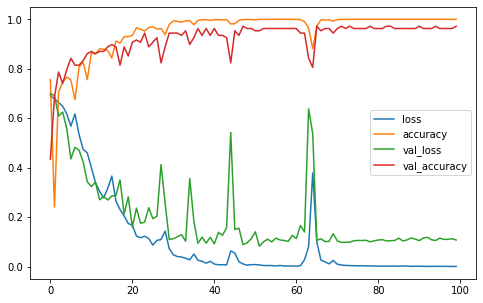

In [30]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9691666603088379
F1_Score  : 0.9282357294367504


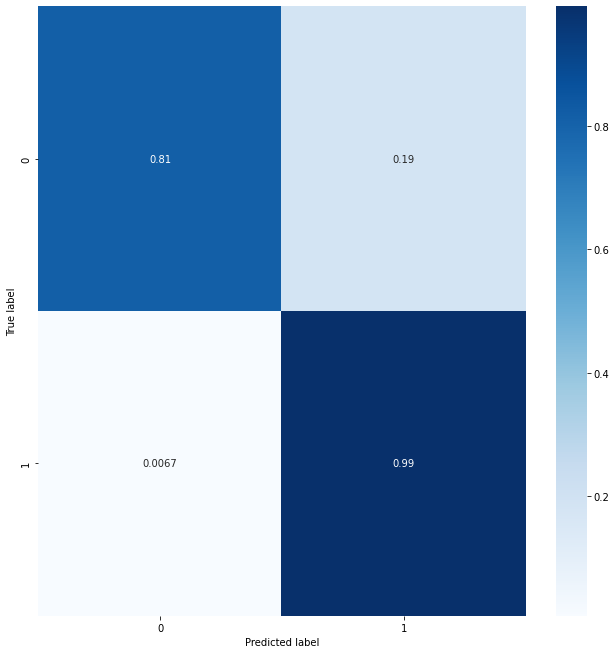

In [31]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 22**

In [32]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(22,23):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.22
(1200, 36, 256, 1)
(1200,) (600,) (600,)
(1200,) (450,) (750,)


3576

# **Valence**

In [33]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6969 - accuracy: 0.5093 - val_loss: 0.6835 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6923 - accuracy: 0.4990 - val_loss: 0.6765 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6891 - accuracy: 0.5381 - val_loss: 0.6989 - val_accuracy: 0.3889
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6678 - accuracy: 0.6039 - val_loss: 0.5696 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6818 - accuracy: 0.5525 - val_loss: 0.6092 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6685 - accuracy: 0.5998 - val_loss: 0.6261 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6231 - accuracy: 0.6728 - val_loss: 0.5407 - val_accu

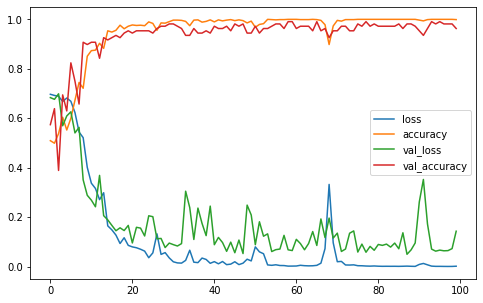

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6951 - accuracy: 0.5144 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6834 - accuracy: 0.5710 - val_loss: 0.6805 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6764 - accuracy: 0.5669 - val_loss: 0.6460 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6229 - accuracy: 0.6914 - val_loss: 0.5890 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.5907 - accuracy: 0.7006 - val_loss: 0.5337 - val_accuracy: 0.8148
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.5131 - accuracy: 0.8025 - val_loss: 0.5333 - val_accuracy: 0.7870
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.4530 - accuracy: 0.8272 - val_loss: 0.5005 - val_accu

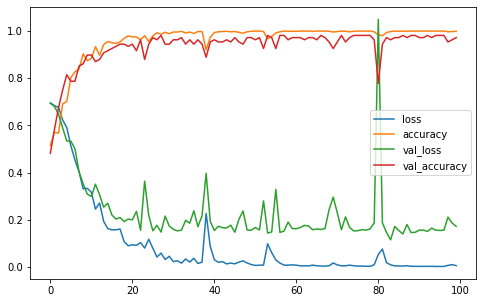

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6941 - accuracy: 0.5175 - val_loss: 0.6854 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6795 - accuracy: 0.5638 - val_loss: 0.6916 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6820 - accuracy: 0.5607 - val_loss: 0.6263 - val_accuracy: 0.6944
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6486 - accuracy: 0.6193 - val_loss: 0.6137 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5439 - accuracy: 0.7335 - val_loss: 0.6358 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4858 - accuracy: 0.7788 - val_loss: 0.4169 - val_accuracy: 0.8148
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.3915 - accuracy: 0.8395 - val_loss: 0.6351 - val_accu

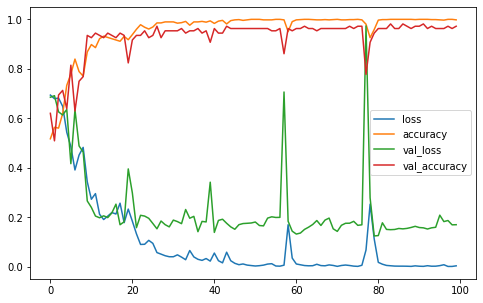

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6978 - accuracy: 0.5041 - val_loss: 0.6966 - val_accuracy: 0.4167
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6862 - accuracy: 0.5525 - val_loss: 0.6829 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6873 - accuracy: 0.5607 - val_loss: 0.6953 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6721 - accuracy: 0.6132 - val_loss: 0.6879 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6507 - accuracy: 0.6235 - val_loss: 0.6423 - val_accuracy: 0.7870
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6148 - accuracy: 0.7006 - val_loss: 0.5731 - val_accuracy: 0.8148
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5549 - accuracy: 0.7819 - val_loss: 0.4748 - val_accu

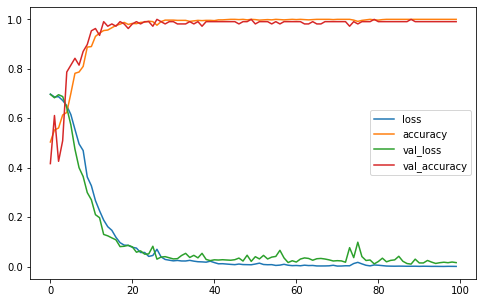

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6895 - accuracy: 0.5463 - val_loss: 0.6861 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6786 - accuracy: 0.5463 - val_loss: 0.6598 - val_accuracy: 0.7593
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6538 - accuracy: 0.6152 - val_loss: 0.6221 - val_accuracy: 0.7222
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5701 - accuracy: 0.7397 - val_loss: 0.5251 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5040 - accuracy: 0.7665 - val_loss: 0.5605 - val_accuracy: 0.7407
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.4847 - accuracy: 0.7778 - val_loss: 0.6466 - val_accuracy: 0.6759
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4103 - accuracy: 0.8333 - val_loss: 0.4542 - val_accu

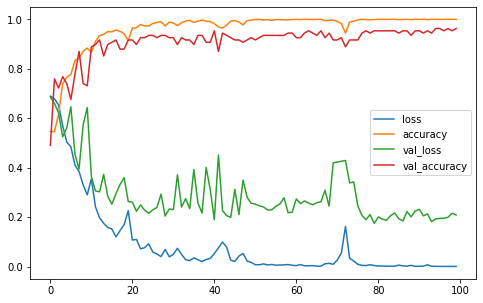

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.7011 - accuracy: 0.5216 - val_loss: 0.7011 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6906 - accuracy: 0.5401 - val_loss: 0.6865 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6943 - accuracy: 0.5041 - val_loss: 0.6848 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6916 - accuracy: 0.5494 - val_loss: 0.6789 - val_accuracy: 0.6204
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6791 - accuracy: 0.5885 - val_loss: 0.6416 - val_accuracy: 0.7685
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6797 - accuracy: 0.5720 - val_loss: 0.6155 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6432 - accuracy: 0.6502 - val_loss: 0.5565 - val_accu

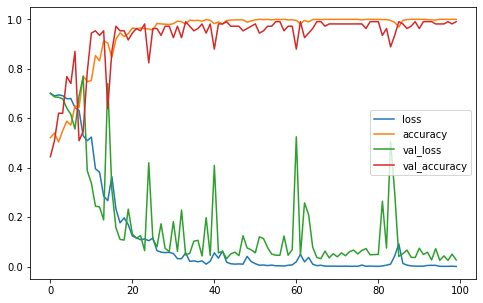

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6976 - accuracy: 0.5257 - val_loss: 0.6835 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6966 - accuracy: 0.5041 - val_loss: 0.6787 - val_accuracy: 0.6296
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6826 - accuracy: 0.5617 - val_loss: 0.6755 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6764 - accuracy: 0.5833 - val_loss: 0.6626 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6270 - accuracy: 0.6471 - val_loss: 0.6665 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5784 - accuracy: 0.7068 - val_loss: 0.4395 - val_accuracy: 0.7685
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.4910 - accuracy: 0.7675 - val_loss: 0.3747 - val_accu

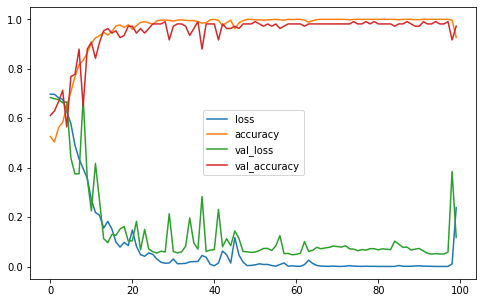

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6967 - accuracy: 0.5041 - val_loss: 0.6891 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6872 - accuracy: 0.5514 - val_loss: 0.6683 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6743 - accuracy: 0.5895 - val_loss: 0.6454 - val_accuracy: 0.7222
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6306 - accuracy: 0.6379 - val_loss: 0.6719 - val_accuracy: 0.5556
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5632 - accuracy: 0.7253 - val_loss: 0.5903 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4869 - accuracy: 0.7716 - val_loss: 0.5632 - val_accuracy: 0.7130
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.5011 - accuracy: 0.7449 - val_loss: 0.5482 - val_accu

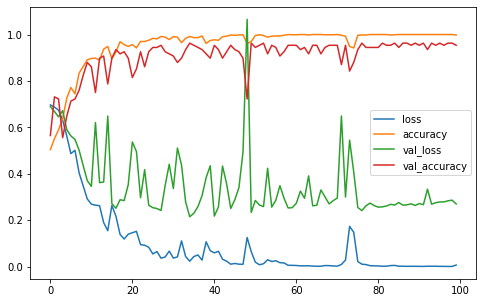

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6946 - accuracy: 0.4825 - val_loss: 0.6805 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6908 - accuracy: 0.5206 - val_loss: 0.6830 - val_accuracy: 0.5463
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6769 - accuracy: 0.5936 - val_loss: 0.6507 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6252 - accuracy: 0.7016 - val_loss: 0.6365 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5437 - accuracy: 0.7428 - val_loss: 0.4846 - val_accuracy: 0.7222
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4483 - accuracy: 0.8200 - val_loss: 0.3761 - val_accuracy: 0.8704
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4439 - accuracy: 0.7973 - val_loss: 0.5315 - val_accu

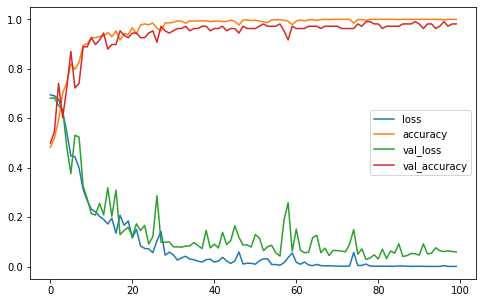

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6953 - accuracy: 0.5103 - val_loss: 0.6909 - val_accuracy: 0.5093
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6883 - accuracy: 0.5504 - val_loss: 0.6801 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6849 - accuracy: 0.5360 - val_loss: 0.6547 - val_accuracy: 0.7963
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6511 - accuracy: 0.6379 - val_loss: 0.6618 - val_accuracy: 0.5278
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6221 - accuracy: 0.6728 - val_loss: 0.4992 - val_accuracy: 0.8611
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5371 - accuracy: 0.7243 - val_loss: 0.4760 - val_accuracy: 0.7870
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.4633 - accuracy: 0.7860 - val_loss: 0.4256 - val_acc

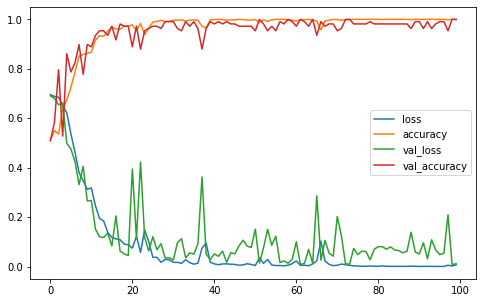

In [34]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9675000011920929
F1_Score  : 0.9668289770665914


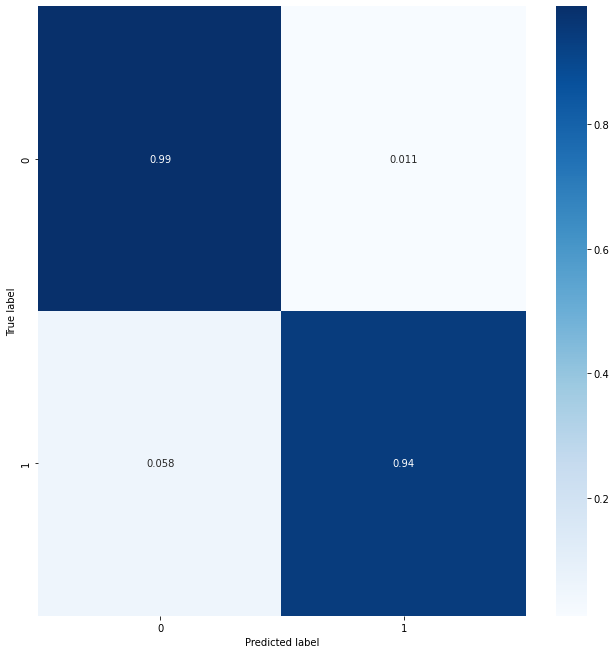

In [35]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [36]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6935 - accuracy: 0.5113 - val_loss: 0.6751 - val_accuracy: 0.6667
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6967 - accuracy: 0.5720 - val_loss: 0.6895 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6899 - accuracy: 0.4599 - val_loss: 0.6848 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6777 - accuracy: 0.4763 - val_loss: 0.6577 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6535 - accuracy: 0.6214 - val_loss: 0.6021 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6405 - accuracy: 0.6656 - val_loss: 0.6558 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6022 - accuracy: 0.7037 - val_loss: 0.5073 - val_accu

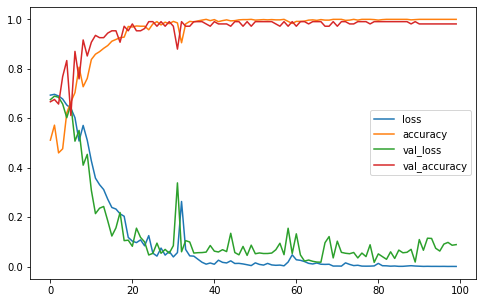

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6891 - accuracy: 0.5000 - val_loss: 0.7079 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6761 - accuracy: 0.6492 - val_loss: 0.7139 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6552 - accuracy: 0.6193 - val_loss: 0.6642 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6128 - accuracy: 0.6914 - val_loss: 0.6928 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5989 - accuracy: 0.6646 - val_loss: 0.5724 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5357 - accuracy: 0.7521 - val_loss: 0.5179 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.4250 - accuracy: 0.8323 - val_loss: 0.5047 - val_accu

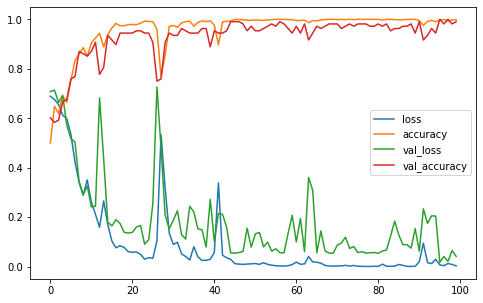

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.7037 - accuracy: 0.5298 - val_loss: 0.7504 - val_accuracy: 0.3889
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.7015 - accuracy: 0.4866 - val_loss: 0.6850 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6881 - accuracy: 0.5432 - val_loss: 0.6826 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6812 - accuracy: 0.5988 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6788 - accuracy: 0.5597 - val_loss: 0.6499 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6657 - accuracy: 0.5761 - val_loss: 0.6307 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6491 - accuracy: 0.6523 - val_loss: 0.5697 - val_accu

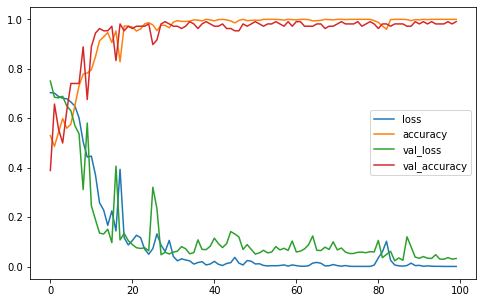

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6977 - accuracy: 0.4918 - val_loss: 0.6766 - val_accuracy: 0.7037
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6919 - accuracy: 0.5113 - val_loss: 0.6654 - val_accuracy: 0.7130
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6842 - accuracy: 0.5761 - val_loss: 0.6662 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6663 - accuracy: 0.6276 - val_loss: 0.6029 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6456 - accuracy: 0.6307 - val_loss: 0.5686 - val_accuracy: 0.7222
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6188 - accuracy: 0.6626 - val_loss: 0.5572 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5485 - accuracy: 0.7418 - val_loss: 0.4824 - val_accu

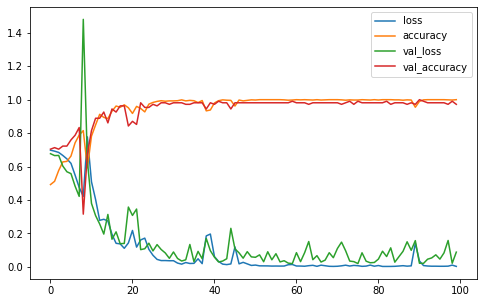

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6983 - accuracy: 0.4938 - val_loss: 0.6810 - val_accuracy: 0.6852
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6869 - accuracy: 0.5226 - val_loss: 0.6715 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6853 - accuracy: 0.5350 - val_loss: 0.6666 - val_accuracy: 0.7593
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6697 - accuracy: 0.6008 - val_loss: 0.6291 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6492 - accuracy: 0.6399 - val_loss: 0.6017 - val_accuracy: 0.7870
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6064 - accuracy: 0.7068 - val_loss: 0.5370 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5615 - accuracy: 0.7294 - val_loss: 0.5531 - val_accu

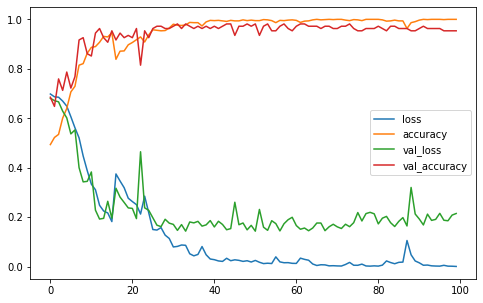

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6974 - accuracy: 0.4588 - val_loss: 0.6908 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6882 - accuracy: 0.5082 - val_loss: 0.6888 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6804 - accuracy: 0.5288 - val_loss: 0.6835 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6799 - accuracy: 0.5484 - val_loss: 0.6924 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6669 - accuracy: 0.5823 - val_loss: 0.6604 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6572 - accuracy: 0.6409 - val_loss: 0.6791 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6147 - accuracy: 0.7181 - val_loss: 0.5590 - val_accu

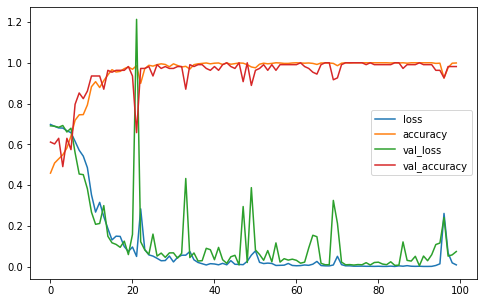

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6935 - accuracy: 0.5370 - val_loss: 0.6914 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6909 - accuracy: 0.4702 - val_loss: 0.6783 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6918 - accuracy: 0.5617 - val_loss: 0.6760 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6720 - accuracy: 0.6049 - val_loss: 0.6253 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6385 - accuracy: 0.6399 - val_loss: 0.6027 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5983 - accuracy: 0.7274 - val_loss: 0.4887 - val_accuracy: 0.8426
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5595 - accuracy: 0.7294 - val_loss: 0.4673 - val_accu

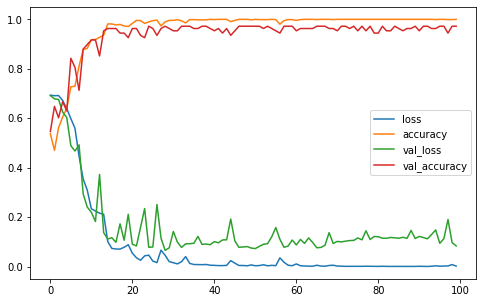

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6871 - accuracy: 0.5247 - val_loss: 0.7004 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6733 - accuracy: 0.6368 - val_loss: 0.6800 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6641 - accuracy: 0.6101 - val_loss: 0.6266 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6311 - accuracy: 0.6903 - val_loss: 0.6067 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.5678 - accuracy: 0.7407 - val_loss: 0.4994 - val_accuracy: 0.8333
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.4995 - accuracy: 0.7912 - val_loss: 0.4296 - val_accuracy: 0.8704
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.4383 - accuracy: 0.8179 - val_loss: 0.3290 - val_accu

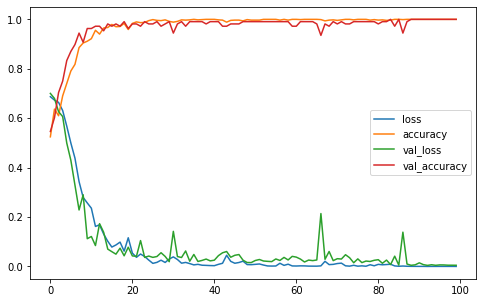

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.7051 - accuracy: 0.5165 - val_loss: 0.6942 - val_accuracy: 0.4537
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6951 - accuracy: 0.4228 - val_loss: 0.6922 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6906 - accuracy: 0.4187 - val_loss: 0.6966 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6887 - accuracy: 0.4630 - val_loss: 0.6795 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6781 - accuracy: 0.5586 - val_loss: 0.6596 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6681 - accuracy: 0.5916 - val_loss: 0.6885 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6947 - accuracy: 0.5432 - val_loss: 0.6439 - val_accu

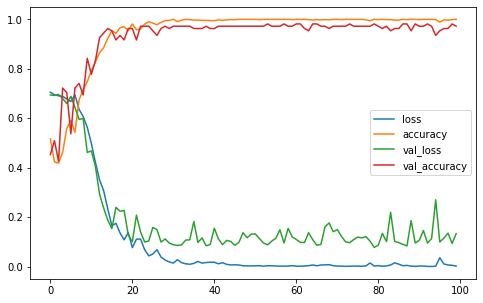

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.7017 - accuracy: 0.4979 - val_loss: 0.6868 - val_accuracy: 0.5833
Epoch 2/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6973 - accuracy: 0.5350 - val_loss: 0.6739 - val_accuracy: 0.6111
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6945 - accuracy: 0.5195 - val_loss: 0.6936 - val_accuracy: 0.4907
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6858 - accuracy: 0.5648 - val_loss: 0.6866 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6874 - accuracy: 0.5669 - val_loss: 0.6830 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6760 - accuracy: 0.5864 - val_loss: 0.6611 - val_accuracy: 0.6019
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6579 - accuracy: 0.6348 - val_loss: 0.6408 - val_acc

In [37]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

In [38]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Accuracy  : 0.9850000143051147
F1_Score  : 0.9816359347361008


# **Subject 23**

In [39]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(23,24):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.23
(1200, 36, 256, 1)
(1200,) (390,) (810,)
(1200,) (810,) (390,)


3576

# **Valence**

In [40]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6935 - accuracy: 0.3385 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6905 - accuracy: 0.3477 - val_loss: 0.7023 - val_accuracy: 0.3611
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6878 - accuracy: 0.4414 - val_loss: 0.6918 - val_accuracy: 0.4537
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6811 - accuracy: 0.4722 - val_loss: 0.6946 - val_accuracy: 0.4537
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6769 - accuracy: 0.6152 - val_loss: 0.7792 - val_accuracy: 0.3611
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6826 - accuracy: 0.5165 - val_loss: 0.6601 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6619 - accuracy: 0.5381 - val_loss: 0.6654 - val_accu

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6945 - accuracy: 0.3128 - val_loss: 0.6926 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6934 - accuracy: 0.5504 - val_loss: 0.6927 - val_accuracy: 0.6204
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6922 - accuracy: 0.3621 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6909 - accuracy: 0.3158 - val_loss: 0.6905 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6879 - accuracy: 0.3879 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6833 - accuracy: 0.5710 - val_loss: 0.6903 - val_accuracy: 0.4815
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6798 - accuracy: 0.4990 - val_loss: 0.6684 - val_accu

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6922 - accuracy: 0.3251 - val_loss: 0.7013 - val_accuracy: 0.3241
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6901 - accuracy: 0.4825 - val_loss: 0.6915 - val_accuracy: 0.5278
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6846 - accuracy: 0.4877 - val_loss: 0.6860 - val_accuracy: 0.5556
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6730 - accuracy: 0.5947 - val_loss: 0.6996 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6558 - accuracy: 0.5967 - val_loss: 0.6644 - val_accuracy: 0.5741
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6354 - accuracy: 0.6307 - val_loss: 0.6547 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5840 - accuracy: 0.7479 - val_loss: 0.6619 - val_accu

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6946 - accuracy: 0.6461 - val_loss: 0.6905 - val_accuracy: 0.7222
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6910 - accuracy: 0.4115 - val_loss: 0.7044 - val_accuracy: 0.3056
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.3405 - val_loss: 0.6946 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6847 - accuracy: 0.5062 - val_loss: 0.7024 - val_accuracy: 0.4630
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6764 - accuracy: 0.5926 - val_loss: 0.6789 - val_accuracy: 0.5556
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6669 - accuracy: 0.6358 - val_loss: 0.7119 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6253 - accuracy: 0.7130 - val_loss: 0.5804 - val_accu

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 86ms/step - loss: 0.6929 - accuracy: 0.3261 - val_loss: 0.7024 - val_accuracy: 0.3148
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6899 - accuracy: 0.3302 - val_loss: 0.7008 - val_accuracy: 0.3241
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6848 - accuracy: 0.4835 - val_loss: 0.6904 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6764 - accuracy: 0.5854 - val_loss: 0.7124 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6660 - accuracy: 0.5484 - val_loss: 0.6704 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6309 - accuracy: 0.6914 - val_loss: 0.6106 - val_accuracy: 0.7963
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5772 - accuracy: 0.7531 - val_loss: 0.5115 - val_accu

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6938 - accuracy: 0.3272 - val_loss: 0.7076 - val_accuracy: 0.3056
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6921 - accuracy: 0.5658 - val_loss: 0.6856 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6890 - accuracy: 0.6605 - val_loss: 0.6950 - val_accuracy: 0.4907
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6847 - accuracy: 0.5545 - val_loss: 0.7131 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6761 - accuracy: 0.4774 - val_loss: 0.7173 - val_accuracy: 0.5093
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6644 - accuracy: 0.5844 - val_loss: 0.6922 - val_accuracy: 0.5926
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6360 - accuracy: 0.7058 - val_loss: 0.7086 - val_accu

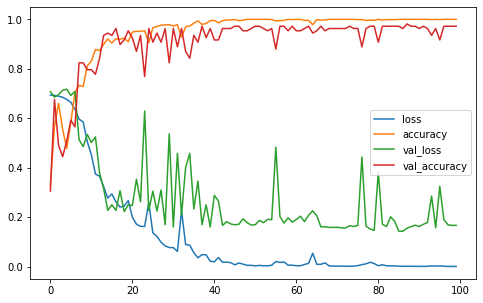

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6931 - accuracy: 0.5278 - val_loss: 0.6993 - val_accuracy: 0.3333
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6910 - accuracy: 0.3447 - val_loss: 0.6948 - val_accuracy: 0.4074
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6891 - accuracy: 0.3467 - val_loss: 0.6944 - val_accuracy: 0.4259
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6855 - accuracy: 0.5905 - val_loss: 0.6902 - val_accuracy: 0.5093
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6766 - accuracy: 0.5329 - val_loss: 0.6629 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6655 - accuracy: 0.6008 - val_loss: 0.7401 - val_accuracy: 0.4630
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6580 - accuracy: 0.6389 - val_loss: 0.6577 - val_accu

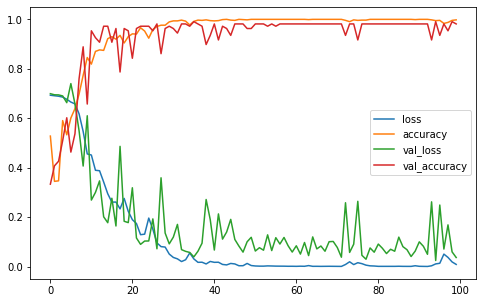

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6938 - accuracy: 0.3457 - val_loss: 0.7003 - val_accuracy: 0.2407
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6915 - accuracy: 0.3477 - val_loss: 0.7017 - val_accuracy: 0.2593
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6887 - accuracy: 0.3879 - val_loss: 0.7102 - val_accuracy: 0.2778
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6855 - accuracy: 0.3549 - val_loss: 0.7194 - val_accuracy: 0.3426
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6714 - accuracy: 0.5082 - val_loss: 0.7257 - val_accuracy: 0.4630
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6529 - accuracy: 0.5967 - val_loss: 0.8279 - val_accuracy: 0.4167
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6296 - accuracy: 0.6656 - val_loss: 0.7469 - val_accu

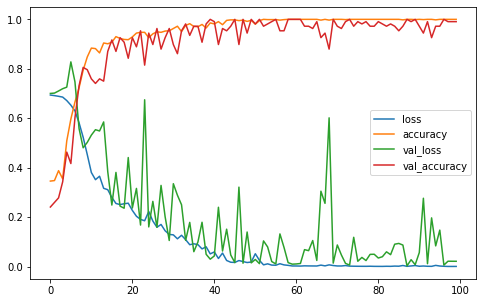

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6922 - accuracy: 0.3724 - val_loss: 0.6937 - val_accuracy: 0.4630
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6893 - accuracy: 0.4537 - val_loss: 0.6887 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6866 - accuracy: 0.6512 - val_loss: 0.6898 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6778 - accuracy: 0.5401 - val_loss: 0.6558 - val_accuracy: 0.7130
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6713 - accuracy: 0.5936 - val_loss: 0.6534 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6482 - accuracy: 0.6770 - val_loss: 0.6192 - val_accuracy: 0.6944
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6241 - accuracy: 0.6842 - val_loss: 0.6401 - val_accu

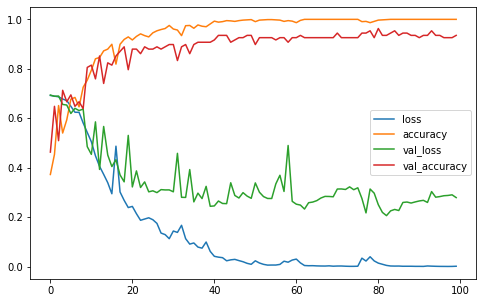

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6928 - accuracy: 0.6440 - val_loss: 0.6911 - val_accuracy: 0.5556
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6900 - accuracy: 0.6553 - val_loss: 0.6922 - val_accuracy: 0.4259
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6874 - accuracy: 0.3693 - val_loss: 0.6752 - val_accuracy: 0.7963
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6807 - accuracy: 0.6975 - val_loss: 0.6836 - val_accuracy: 0.4907
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6815 - accuracy: 0.5535 - val_loss: 0.6579 - val_accuracy: 0.6944
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6670 - accuracy: 0.5391 - val_loss: 0.6336 - val_accuracy: 0.8241
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6323 - accuracy: 0.7006 - val_loss: 0.5649 - val_acc

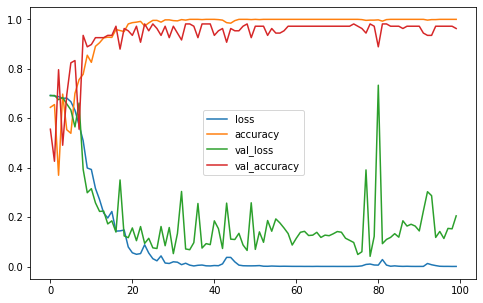

In [41]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9549999952316284
F1_Score  : 0.9473214410661062


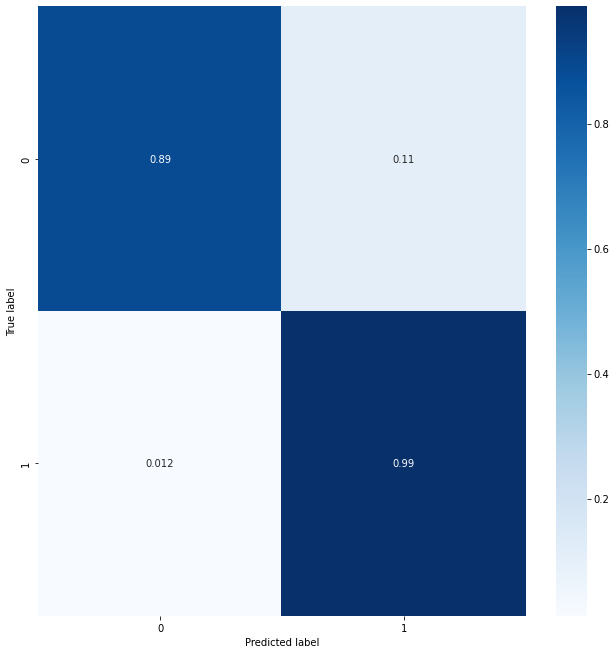

In [42]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [43]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 79ms/step - loss: 0.6926 - accuracy: 0.6389 - val_loss: 0.6917 - val_accuracy: 0.6296
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6914 - accuracy: 0.3837 - val_loss: 0.6907 - val_accuracy: 0.5741
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6920 - accuracy: 0.6780 - val_loss: 0.6793 - val_accuracy: 0.6759
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6872 - accuracy: 0.5360 - val_loss: 0.6823 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6785 - accuracy: 0.7037 - val_loss: 0.6802 - val_accuracy: 0.5185
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6635 - accuracy: 0.6080 - val_loss: 0.6671 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6395 - accuracy: 0.6492 - val_loss: 0.5860 - val_accu

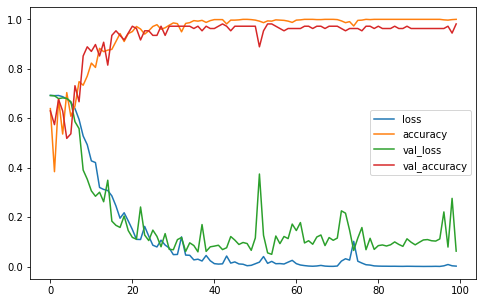

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6939 - accuracy: 0.5648 - val_loss: 0.6871 - val_accuracy: 0.7037
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6922 - accuracy: 0.6852 - val_loss: 0.6856 - val_accuracy: 0.7222
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6917 - accuracy: 0.5195 - val_loss: 0.6854 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6896 - accuracy: 0.6893 - val_loss: 0.6700 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6858 - accuracy: 0.5751 - val_loss: 0.6551 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6797 - accuracy: 0.6842 - val_loss: 0.6758 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6640 - accuracy: 0.6502 - val_loss: 0.6764 - val_accu

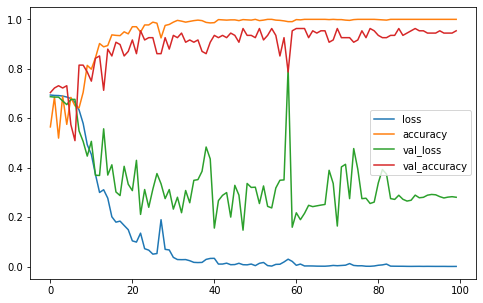

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6931 - accuracy: 0.6451 - val_loss: 0.6923 - val_accuracy: 0.4907
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6911 - accuracy: 0.6348 - val_loss: 0.6860 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6890 - accuracy: 0.6296 - val_loss: 0.6838 - val_accuracy: 0.7037
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6846 - accuracy: 0.6965 - val_loss: 0.6631 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6735 - accuracy: 0.6718 - val_loss: 0.7441 - val_accuracy: 0.2870
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6547 - accuracy: 0.6389 - val_loss: 0.6027 - val_accuracy: 0.7407
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5878 - accuracy: 0.6914 - val_loss: 0.5375 - val_accu

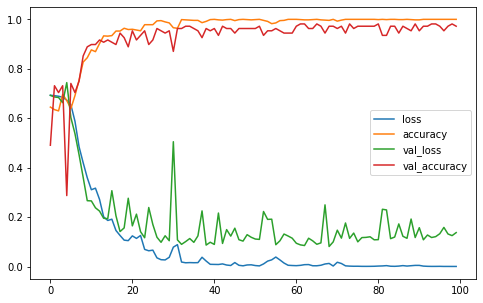

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6922 - accuracy: 0.3652 - val_loss: 0.6917 - val_accuracy: 0.5741
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6904 - accuracy: 0.6049 - val_loss: 0.6874 - val_accuracy: 0.6574
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6849 - accuracy: 0.6512 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6739 - accuracy: 0.5700 - val_loss: 0.6436 - val_accuracy: 0.6852
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6453 - accuracy: 0.6605 - val_loss: 0.7851 - val_accuracy: 0.3889
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6722 - accuracy: 0.5792 - val_loss: 0.6363 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6404 - accuracy: 0.7212 - val_loss: 0.5995 - val_accu

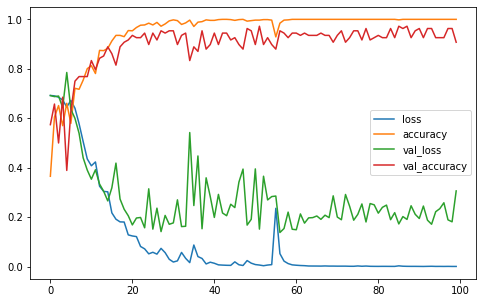

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6931 - accuracy: 0.3416 - val_loss: 0.6939 - val_accuracy: 0.3611
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.6327 - val_loss: 0.6858 - val_accuracy: 0.6759
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6909 - accuracy: 0.6543 - val_loss: 0.6901 - val_accuracy: 0.6019
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6871 - accuracy: 0.4897 - val_loss: 0.6826 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6828 - accuracy: 0.6420 - val_loss: 0.6980 - val_accuracy: 0.4259
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6660 - accuracy: 0.6471 - val_loss: 0.6495 - val_accuracy: 0.6111
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6288 - accuracy: 0.6337 - val_loss: 0.5599 - val_accu

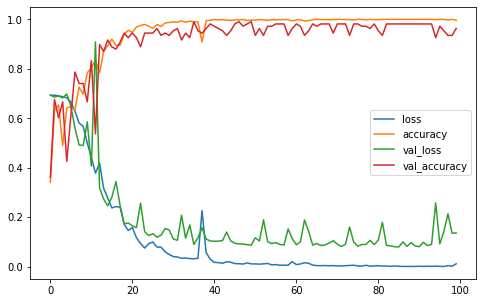

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6928 - accuracy: 0.6595 - val_loss: 0.6913 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6906 - accuracy: 0.6646 - val_loss: 0.6924 - val_accuracy: 0.5093
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6888 - accuracy: 0.5761 - val_loss: 0.6800 - val_accuracy: 0.6852
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6825 - accuracy: 0.6944 - val_loss: 0.6825 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6702 - accuracy: 0.7047 - val_loss: 0.6442 - val_accuracy: 0.6852
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6472 - accuracy: 0.6358 - val_loss: 0.5908 - val_accuracy: 0.7222
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6155 - accuracy: 0.6831 - val_loss: 0.5304 - val_accu

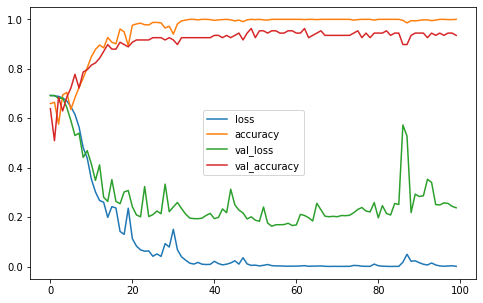

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6930 - accuracy: 0.5309 - val_loss: 0.6888 - val_accuracy: 0.7685
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6916 - accuracy: 0.6821 - val_loss: 0.6879 - val_accuracy: 0.7315
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6903 - accuracy: 0.5833 - val_loss: 0.6914 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6876 - accuracy: 0.6605 - val_loss: 0.6799 - val_accuracy: 0.7500
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6822 - accuracy: 0.6255 - val_loss: 0.6723 - val_accuracy: 0.7315
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6643 - accuracy: 0.7037 - val_loss: 0.6595 - val_accuracy: 0.5833
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6267 - accuracy: 0.6903 - val_loss: 0.5524 - val_accu

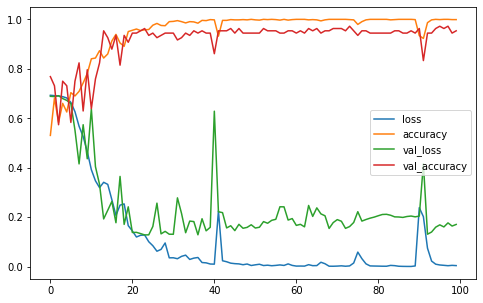

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6928 - accuracy: 0.6831 - val_loss: 0.6874 - val_accuracy: 0.6204
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6915 - accuracy: 0.6430 - val_loss: 0.6897 - val_accuracy: 0.6481
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6890 - accuracy: 0.6986 - val_loss: 0.6823 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6826 - accuracy: 0.6800 - val_loss: 0.7013 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6721 - accuracy: 0.5586 - val_loss: 0.6894 - val_accuracy: 0.4444
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6475 - accuracy: 0.5844 - val_loss: 0.6625 - val_accuracy: 0.5370
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6226 - accuracy: 0.6800 - val_loss: 0.7044 - val_accu

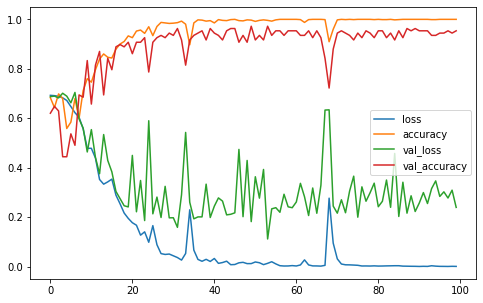

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 86ms/step - loss: 0.6933 - accuracy: 0.6533 - val_loss: 0.6906 - val_accuracy: 0.6759
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6920 - accuracy: 0.3827 - val_loss: 0.6968 - val_accuracy: 0.2963
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6908 - accuracy: 0.3961 - val_loss: 0.6882 - val_accuracy: 0.5648
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6868 - accuracy: 0.4527 - val_loss: 0.6608 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6816 - accuracy: 0.6060 - val_loss: 0.6433 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6639 - accuracy: 0.6070 - val_loss: 0.6128 - val_accuracy: 0.7593
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6177 - accuracy: 0.7037 - val_loss: 0.5219 - val_accu

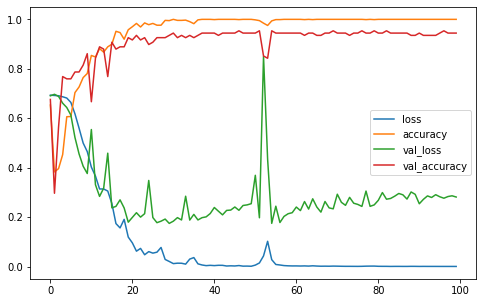

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6932 - accuracy: 0.3786 - val_loss: 0.6942 - val_accuracy: 0.3704
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6922 - accuracy: 0.3477 - val_loss: 0.6945 - val_accuracy: 0.3704
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.4177 - val_loss: 0.6804 - val_accuracy: 0.6574
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6858 - accuracy: 0.5741 - val_loss: 0.6643 - val_accuracy: 0.6667
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6748 - accuracy: 0.6132 - val_loss: 0.6558 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6426 - accuracy: 0.6800 - val_loss: 0.9093 - val_accuracy: 0.3704
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6687 - accuracy: 0.6214 - val_loss: 0.6644 - val_acc

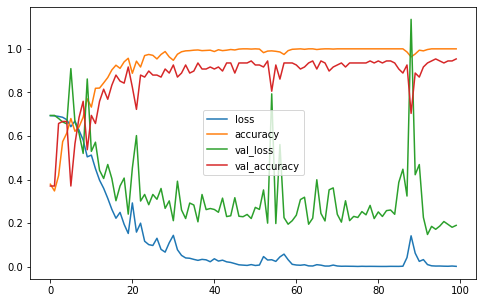

In [44]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9316666722297668
F1_Score  : 0.9232423328117243


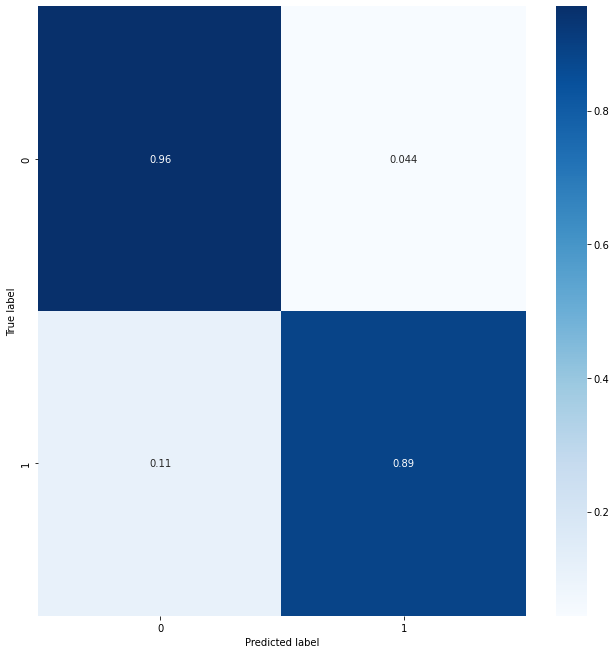

In [45]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 24**

In [46]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(24,25):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.24
(1200, 36, 256, 1)
(1200,) (630,) (570,)
(1200,) (210,) (990,)


3576

# **Valence**

In [47]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6922 - accuracy: 0.5370 - val_loss: 0.7000 - val_accuracy: 0.4815
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6942 - accuracy: 0.5401 - val_loss: 0.6850 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6895 - accuracy: 0.5669 - val_loss: 0.6860 - val_accuracy: 0.6481
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6835 - accuracy: 0.5741 - val_loss: 0.6820 - val_accuracy: 0.5741
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6632 - accuracy: 0.6255 - val_loss: 0.6532 - val_accuracy: 0.6759
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6446 - accuracy: 0.6142 - val_loss: 0.6266 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6539 - accuracy: 0.6317 - val_loss: 0.7026 - val_accu

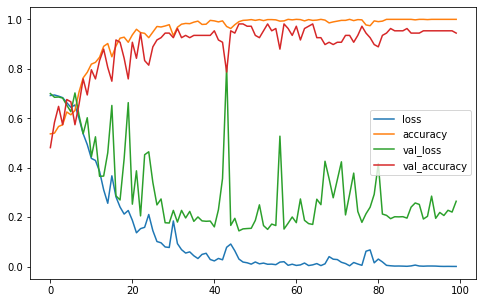

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 79ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6970 - val_accuracy: 0.4259
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6931 - accuracy: 0.4856 - val_loss: 0.7014 - val_accuracy: 0.3704
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6918 - accuracy: 0.5247 - val_loss: 0.6832 - val_accuracy: 0.6296
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6890 - accuracy: 0.5617 - val_loss: 0.6717 - val_accuracy: 0.6296
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6871 - accuracy: 0.5340 - val_loss: 0.6694 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6876 - accuracy: 0.5412 - val_loss: 0.6903 - val_accuracy: 0.4907
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6878 - accuracy: 0.5093 - val_loss: 0.6861 - val_accu

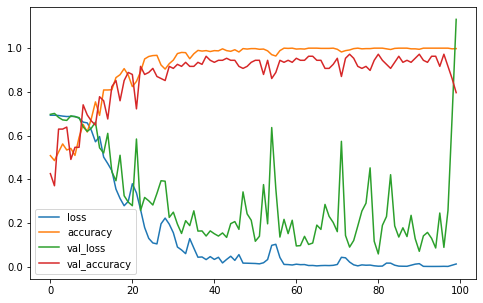

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6948 - accuracy: 0.4877 - val_loss: 0.6914 - val_accuracy: 0.6111
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6908 - accuracy: 0.5514 - val_loss: 0.6909 - val_accuracy: 0.5185
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6868 - accuracy: 0.5700 - val_loss: 0.6904 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6828 - accuracy: 0.5844 - val_loss: 0.6848 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6724 - accuracy: 0.5813 - val_loss: 0.6786 - val_accuracy: 0.6111
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6781 - accuracy: 0.5782 - val_loss: 0.6653 - val_accuracy: 0.6389
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6545 - accuracy: 0.6368 - val_loss: 0.6567 - val_accu

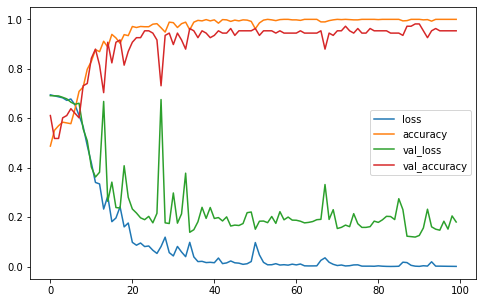

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6924 - accuracy: 0.5247 - val_loss: 0.7008 - val_accuracy: 0.4444
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6921 - accuracy: 0.5730 - val_loss: 0.6889 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6872 - accuracy: 0.5947 - val_loss: 0.7153 - val_accuracy: 0.4444
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6830 - accuracy: 0.5813 - val_loss: 0.7008 - val_accuracy: 0.4444
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6888 - accuracy: 0.5689 - val_loss: 0.6780 - val_accuracy: 0.7037
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6795 - accuracy: 0.6307 - val_loss: 0.6744 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6741 - accuracy: 0.5977 - val_loss: 0.6473 - val_accu

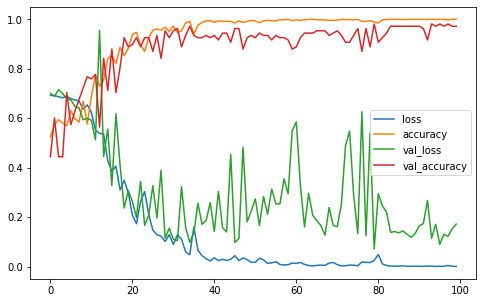

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6938 - accuracy: 0.5082 - val_loss: 0.6898 - val_accuracy: 0.5463
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6913 - accuracy: 0.5525 - val_loss: 0.6865 - val_accuracy: 0.6944
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6906 - accuracy: 0.5309 - val_loss: 0.6884 - val_accuracy: 0.5185
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6860 - accuracy: 0.5844 - val_loss: 0.6690 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6802 - accuracy: 0.5751 - val_loss: 0.6625 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6515 - accuracy: 0.6193 - val_loss: 0.7071 - val_accuracy: 0.4907
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6561 - accuracy: 0.6101 - val_loss: 0.6422 - val_accu

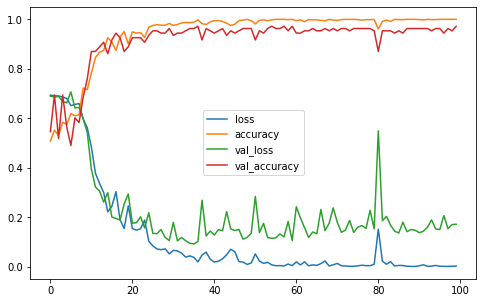

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6923 - accuracy: 0.5165 - val_loss: 0.6901 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6899 - accuracy: 0.5175 - val_loss: 0.6900 - val_accuracy: 0.5648
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6940 - accuracy: 0.5123 - val_loss: 0.6835 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6889 - accuracy: 0.5473 - val_loss: 0.6822 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6860 - accuracy: 0.5195 - val_loss: 0.6820 - val_accuracy: 0.6389
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6797 - accuracy: 0.5957 - val_loss: 0.6661 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6674 - accuracy: 0.6193 - val_loss: 0.6456 - val_accu

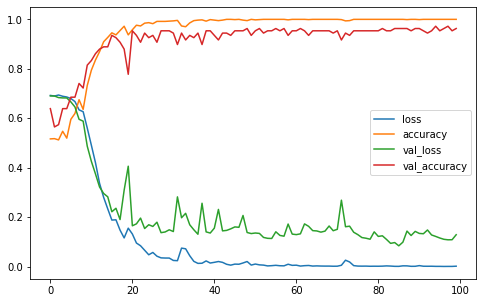

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6947 - accuracy: 0.5082 - val_loss: 0.6890 - val_accuracy: 0.6019
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6924 - accuracy: 0.5340 - val_loss: 0.6912 - val_accuracy: 0.5833
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6938 - accuracy: 0.5267 - val_loss: 0.6897 - val_accuracy: 0.6204
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6918 - accuracy: 0.5422 - val_loss: 0.6914 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6893 - accuracy: 0.5319 - val_loss: 0.6855 - val_accuracy: 0.6481
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6896 - accuracy: 0.5535 - val_loss: 0.6947 - val_accuracy: 0.4259
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6832 - accuracy: 0.5607 - val_loss: 0.6757 - val_accu

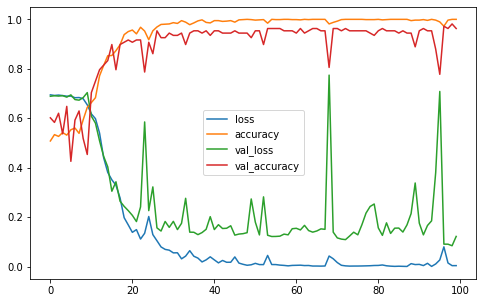

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6957 - accuracy: 0.4866 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6911 - accuracy: 0.5412 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6900 - accuracy: 0.5576 - val_loss: 0.6894 - val_accuracy: 0.5093
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6908 - accuracy: 0.4938 - val_loss: 0.6896 - val_accuracy: 0.6389
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6792 - accuracy: 0.6019 - val_loss: 0.6780 - val_accuracy: 0.6296
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6641 - accuracy: 0.5977 - val_loss: 0.6773 - val_accuracy: 0.5278
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6451 - accuracy: 0.6255 - val_loss: 0.6517 - val_accu

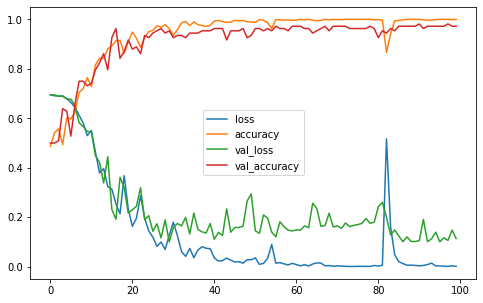

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 83ms/step - loss: 0.6943 - accuracy: 0.5103 - val_loss: 0.6876 - val_accuracy: 0.5648
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6909 - accuracy: 0.5278 - val_loss: 0.6875 - val_accuracy: 0.6389
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6928 - accuracy: 0.5422 - val_loss: 0.6851 - val_accuracy: 0.5926
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6951 - accuracy: 0.5237 - val_loss: 0.6874 - val_accuracy: 0.7685
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6898 - accuracy: 0.5566 - val_loss: 0.6791 - val_accuracy: 0.7593
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6869 - accuracy: 0.5473 - val_loss: 0.6706 - val_accuracy: 0.5556
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6851 - accuracy: 0.5628 - val_loss: 0.6702 - val_accu

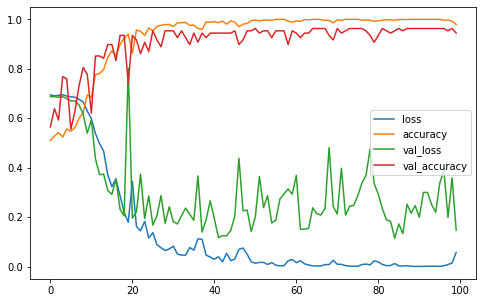

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6949 - accuracy: 0.5082 - val_loss: 0.6881 - val_accuracy: 0.5370
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6941 - accuracy: 0.4733 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6904 - accuracy: 0.5432 - val_loss: 0.6858 - val_accuracy: 0.5370
Epoch 4/100
16/16 [==============================] - 1s 61ms/step - loss: 0.6883 - accuracy: 0.5802 - val_loss: 0.6861 - val_accuracy: 0.6019
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6867 - accuracy: 0.5381 - val_loss: 0.6734 - val_accuracy: 0.5463
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6675 - accuracy: 0.6317 - val_loss: 0.6434 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6516 - accuracy: 0.6235 - val_loss: 0.6094 - val_acc

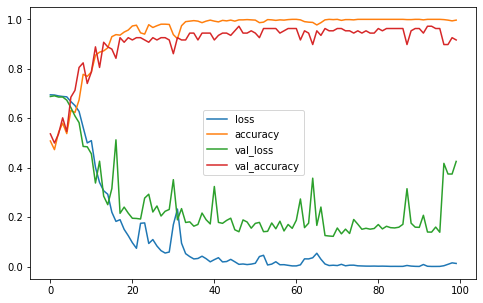

In [48]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9158333301544189
F1_Score  : 0.9153547998429671


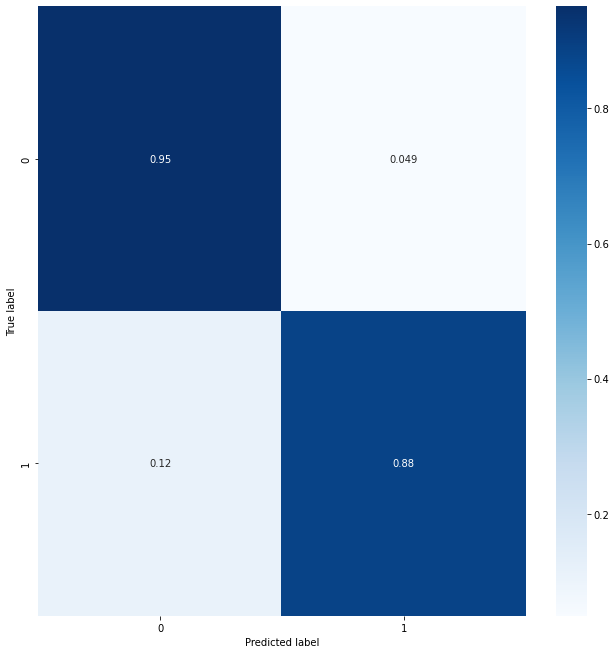

In [49]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [50]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/100
16/16 [==============================] - 3s 80ms/step - loss: 0.6758 - accuracy: 0.7253 - val_loss: 0.5423 - val_accuracy: 0.8519
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6594 - accuracy: 0.5947 - val_loss: 0.5759 - val_accuracy: 0.6019
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6504 - accuracy: 0.6481 - val_loss: 0.7048 - val_accuracy: 0.4630
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6430 - accuracy: 0.5844 - val_loss: 0.6881 - val_accuracy: 0.5370
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6272 - accuracy: 0.5854 - val_loss: 0.4498 - val_accuracy: 0.8056
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6056 - accuracy: 0.6307 - val_loss: 0.4939 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 0.5355 - accuracy: 0.6955 - val_loss: 0.4062 - val_accu

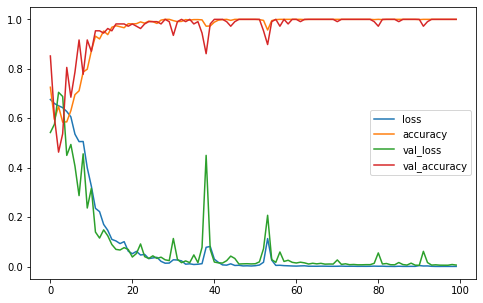

Results for fold 2
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6748 - accuracy: 0.8138 - val_loss: 0.6067 - val_accuracy: 0.7685
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6588 - accuracy: 0.6348 - val_loss: 0.5086 - val_accuracy: 0.8333
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6904 - accuracy: 0.5751 - val_loss: 0.6565 - val_accuracy: 0.4722
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6451 - accuracy: 0.6595 - val_loss: 0.6508 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6228 - accuracy: 0.5782 - val_loss: 0.5325 - val_accuracy: 0.6667
Epoch 6/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6505 - accuracy: 0.5720 - val_loss: 0.5542 - val_accuracy: 0.6296
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6216 - accuracy: 0.6214 - val_loss: 0.5908 - val_accu

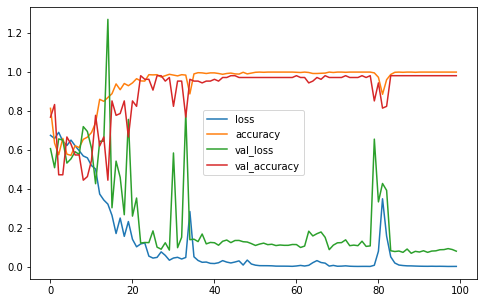

Results for fold 3
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6880 - accuracy: 0.7809 - val_loss: 0.6673 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.6754 - accuracy: 0.7459 - val_loss: 0.6018 - val_accuracy: 0.7130
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6575 - accuracy: 0.6193 - val_loss: 0.5329 - val_accuracy: 0.7315
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6438 - accuracy: 0.5905 - val_loss: 0.5422 - val_accuracy: 0.6944
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6384 - accuracy: 0.5916 - val_loss: 0.6597 - val_accuracy: 0.4907
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6196 - accuracy: 0.5792 - val_loss: 0.5331 - val_accuracy: 0.6852
Epoch 7/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5713 - accuracy: 0.6245 - val_loss: 0.7560 - val_accu

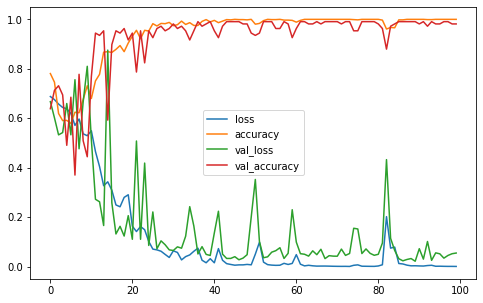

Results for fold 4
Epoch 1/100
16/16 [==============================] - 3s 81ms/step - loss: 0.6880 - accuracy: 0.8158 - val_loss: 0.6566 - val_accuracy: 0.8519
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6728 - accuracy: 0.7613 - val_loss: 0.6286 - val_accuracy: 0.5926
Epoch 3/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6547 - accuracy: 0.7202 - val_loss: 0.6301 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6438 - accuracy: 0.6132 - val_loss: 0.5822 - val_accuracy: 0.6111
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6337 - accuracy: 0.6265 - val_loss: 0.5442 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6196 - accuracy: 0.6070 - val_loss: 0.5284 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5899 - accuracy: 0.6451 - val_loss: 0.4649 - val_accu

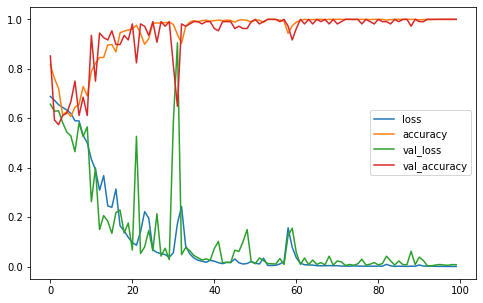

Results for fold 5
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6812 - accuracy: 0.7593 - val_loss: 0.5572 - val_accuracy: 0.8148
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6663 - accuracy: 0.6739 - val_loss: 0.5598 - val_accuracy: 0.7870
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6533 - accuracy: 0.6440 - val_loss: 0.5958 - val_accuracy: 0.6481
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6248 - accuracy: 0.6245 - val_loss: 0.5507 - val_accuracy: 0.6574
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6241 - accuracy: 0.6121 - val_loss: 0.6468 - val_accuracy: 0.5370
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5997 - accuracy: 0.6214 - val_loss: 0.6343 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5429 - accuracy: 0.6770 - val_loss: 0.6434 - val_accu

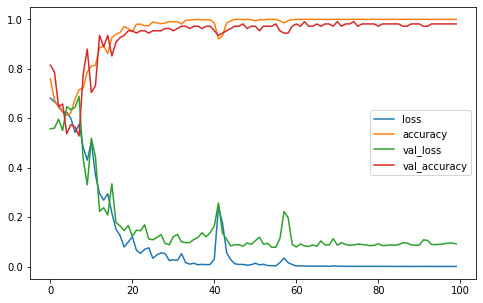

Results for fold 6
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6869 - accuracy: 0.8272 - val_loss: 0.6321 - val_accuracy: 0.7593
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6806 - accuracy: 0.8354 - val_loss: 0.6517 - val_accuracy: 0.7130
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6668 - accuracy: 0.8179 - val_loss: 0.6388 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6777 - accuracy: 0.4578 - val_loss: 0.5965 - val_accuracy: 0.7963
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6653 - accuracy: 0.7099 - val_loss: 0.6366 - val_accuracy: 0.5093
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6274 - accuracy: 0.7047 - val_loss: 0.5758 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6274 - accuracy: 0.6492 - val_loss: 0.5921 - val_accu

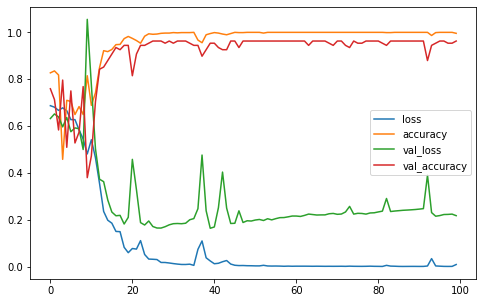

Results for fold 7
Epoch 1/100
16/16 [==============================] - 3s 86ms/step - loss: 0.6830 - accuracy: 0.6800 - val_loss: 0.5816 - val_accuracy: 0.8704
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6748 - accuracy: 0.7449 - val_loss: 0.6814 - val_accuracy: 0.4630
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6586 - accuracy: 0.6224 - val_loss: 0.6172 - val_accuracy: 0.5741
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6453 - accuracy: 0.6553 - val_loss: 0.5965 - val_accuracy: 0.5648
Epoch 5/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6211 - accuracy: 0.6008 - val_loss: 0.5498 - val_accuracy: 0.6204
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6103 - accuracy: 0.6163 - val_loss: 0.5324 - val_accuracy: 0.6204
Epoch 7/100
16/16 [==============================] - 1s 60ms/step - loss: 0.5759 - accuracy: 0.6842 - val_loss: 0.4450 - val_accu

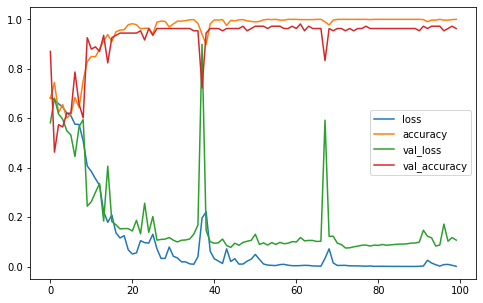

Results for fold 8
Epoch 1/100
16/16 [==============================] - 3s 84ms/step - loss: 0.6791 - accuracy: 0.8282 - val_loss: 0.6147 - val_accuracy: 0.7963
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6627 - accuracy: 0.6584 - val_loss: 0.6079 - val_accuracy: 0.7407
Epoch 3/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6561 - accuracy: 0.6708 - val_loss: 0.6667 - val_accuracy: 0.5278
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6444 - accuracy: 0.6626 - val_loss: 0.6856 - val_accuracy: 0.4722
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6284 - accuracy: 0.5926 - val_loss: 0.6037 - val_accuracy: 0.5648
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6141 - accuracy: 0.6440 - val_loss: 0.6987 - val_accuracy: 0.4722
Epoch 7/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5990 - accuracy: 0.6214 - val_loss: 0.5361 - val_accu

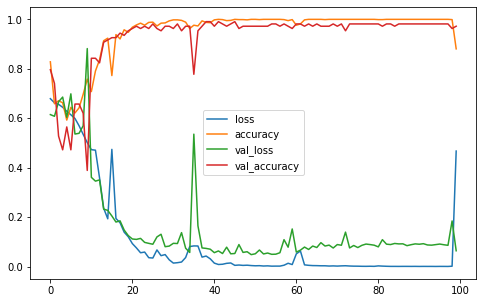

Results for fold 9
Epoch 1/100
16/16 [==============================] - 3s 85ms/step - loss: 0.6822 - accuracy: 0.8251 - val_loss: 0.6114 - val_accuracy: 0.8241
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6820 - accuracy: 0.7582 - val_loss: 0.6551 - val_accuracy: 0.8241
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6819 - accuracy: 0.8200 - val_loss: 0.6160 - val_accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6699 - accuracy: 0.5833 - val_loss: 0.5928 - val_accuracy: 0.7222
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6559 - accuracy: 0.7150 - val_loss: 0.6258 - val_accuracy: 0.5278
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 0.6425 - accuracy: 0.5185 - val_loss: 0.5422 - val_accuracy: 0.6667
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6445 - accuracy: 0.6533 - val_loss: 0.6141 - val_accu

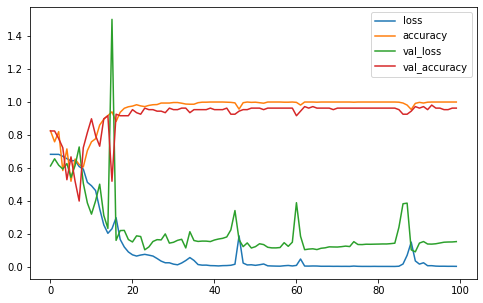

Results for fold 10
Epoch 1/100
16/16 [==============================] - 3s 82ms/step - loss: 0.6858 - accuracy: 0.5782 - val_loss: 0.5749 - val_accuracy: 0.8519
Epoch 2/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6659 - accuracy: 0.7870 - val_loss: 0.7086 - val_accuracy: 0.2870
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6592 - accuracy: 0.4558 - val_loss: 0.4725 - val_accuracy: 0.8241
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6482 - accuracy: 0.6235 - val_loss: 0.5369 - val_accuracy: 0.7315
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6337 - accuracy: 0.6461 - val_loss: 0.6329 - val_accuracy: 0.6019
Epoch 6/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6122 - accuracy: 0.6749 - val_loss: 0.6405 - val_accuracy: 0.5741
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5839 - accuracy: 0.6842 - val_loss: 0.6524 - val_acc

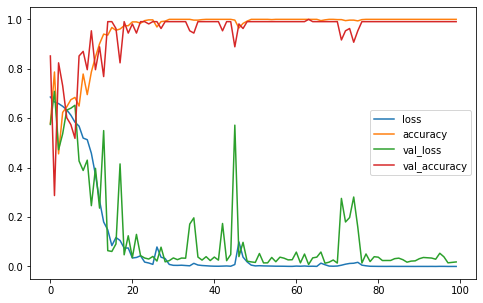

In [51]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9750000059604644
F1_Score  : 0.9570969956079152


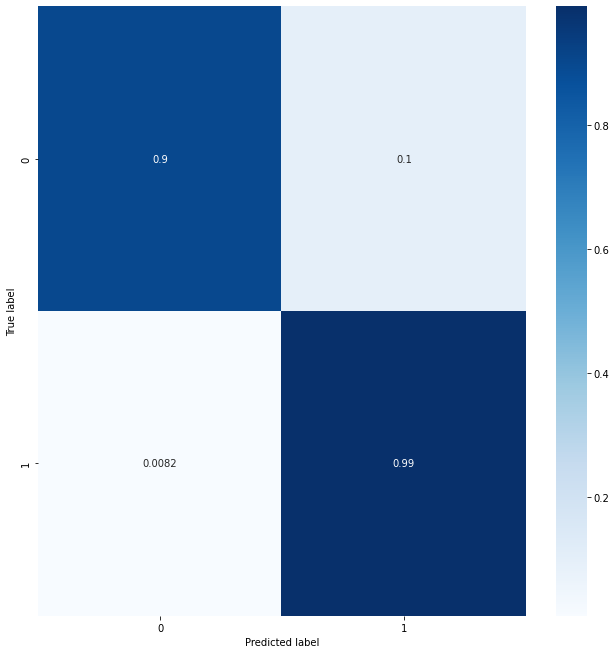

In [52]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()